#  Table Extractor Experiment
### 실험 데이터
   - 표1: 정보 복잡도 높음
   - 표2: 비정형
   - 표3: 공백 포함
   - 표4: 비정형성 높음, 중첩표
   - 표5: 쉬움

### 테이블 변환 실험
   * 결과
     1. gpt-4o 모델이 원본 테이블 구조, 정보 추출 성능 우수하며, 합리적 비용 내 존재
     2. 표 제목이 없는 경우에 더 좋은 결과물 출력
     3. 이미지 크기가 크면 변환 결과가 좋으나, 정보 복잡도가 높은 이미지(표1)의 변환은 해결하지 못함.
        * 프롬프트 엔지니어링 또는 고성능 모델(추론모델) 통한 개선 필요
   * 실험 변인
     1. 모델간 비교(gpt-4o, gpt-4o-mini)
     2. 추가 정보 비교(표 제목 포함 유무)
     3. 이미지 크기 전처리 유무

### 정보 추출 실험
   * 결과
     - gpt-4o 모델의 결과가 핵심 내용이 중심이된 내용으로 구성
     - table의 형식을 나타내는 이미지나 예시 이미지에서 성능 차이가 확연하게 나타남
   * 실험변인
     1. 모델간 비교(gpt-4o, gpt-4o-mini)
     2. 프롬프트(key insights에 대한 정의)

### 변환 및 정보 추출 단계 기준 실험
   * 결과: 변환 및 정보 추출을 개별 진행방식이 적합
   * 변환과 정보 추출을 동시에 진행

In [1]:
import os
import json
import yaml

from pprint import pprint
from IPython.display import Image, display

from typing import TypedDict, Annotated, List, Dict, Tuple

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import load_prompt

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('../data/document/역도/documentParseGraph_state.json', 'r') as f:
    state = json.load(f)

class GraphState(TypedDict):
    filepath: Annotated[str, 'filepath']
    filepath_pdf: Annotated[str, 'pdf filepath']
    originData: Annotated[List[Dict], 'originData']
    documents: Annotated[List[Dict], 'documents']
    heading_structure: Annotated[List[str], 'heading structure. last heading is borderline']
    unused_elements: Annotated[List[Tuple[str, str]], 'unused elements']
    image_result: Annotated[List[Dict], 'result of image information extractor ']
    chart_result: Annotated[List[Dict], 'result of chart information extractor ']
    table_result: Annotated[List[Dict], 'result of table information extractor ']
    
state = GraphState(**state)

In [22]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        image_content = image_file.read()
        file_ext = os.path.splitext(image_path)[1].lower()

        if file_ext in ['.jpg', '.jpeg']:
            mime_type = 'image/jpeg'
        elif file_ext == '.png':
            mime_type = 'image/png'
        else:
            mime_type = 'image/unknown'

        return base64.b64encode(image_content).decode("utf-8"), mime_type


In [4]:
def load_prompt(yaml_file):
    with open(yaml_file, "r", encoding="utf-8") as file:
        return yaml.safe_load(file)

In [5]:
def printToken(result_message, model_name):
    input_token = result_message.response_metadata['token_usage']['completion_tokens']
    output_token = result_message.response_metadata['token_usage']['prompt_tokens']

    if model_name == 'gpt-4o':
        input_dolor = round(input_token * 0.000001 * 2.5, 5)
        output_dolor = round(output_token * 0.000001 * 10, 5)
    elif model_name == 'gpt-4o-mini':
        input_dolor = round(input_token * 0.000001 * 0.15, 5)
        output_dolor = round(output_token * 0.000001 * 0.6, 5)

    input_won = round(input_dolor * 1440)
    output_won = round(output_dolor * 1440)

    print(f"input: {input_token},  {input_dolor}$, {input_won}원")
    print(f"output: {output_token},  {output_dolor}$, {output_won}원")

In [6]:
def parse_json_string(json_str):
    try:
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"JSON 파싱 에러: {e}")
        return None

## 실험 데이터


In [7]:
base_dataset = [
    {'image_path':'../data/experiment/informationExtract/table/information/information_1.png',
     'title': '표 5. 보조프로그램의 주동근 동원 순서',
     'context': '인상기술 향상을 위한 보조훈련의 효과검증 결과, 국면별(1~4국면) 보조프로그램들의 근육활용도가 표로 제시되어 있습니다. 특정 국면에서 특정 근육을 강화하기 위해 이 표를 참조하면 더 효과적인 훈련이 가능합니다.',
     'description': '정보 복잡도 높음'},
    {'image_path':'../data/experiment/informationExtract/table/information/information_2.png',
     'title': '표 8. 동기유발 훈련방법',
     'context': '우수한 역도 선수의 특징 중 하나는 높은 의욕과 동기입니다. 동기는 목표 달성을 위한 노력의 정도와 관련되며, 우수한 선수로 성장하는 데 중요한 요소이므로 지도자는 선수의 동기 강화와 적극적 참여 방법에 관심을 가져야 합니다',
     'description': '비정형성 높음'},
     {'image_path':'../data/experiment/informationExtract/table/information/information_3.png',
     'title': '표 7. 시합반성 자기 진단표',
     'context': '심리기술훈련은 스포츠 수행 촉진과 긍정적 접근을 위해 심리 특성을 강화하는 기법과 전략입니다. 이는 심리기술(훈련의 최종 목표)과 심리 방법(기술 발달을 위한 절차나 기법)으로 구분됩니다.',
     'description': '비정형성 높음, 중첩표'},
     {'image_path':'../data/experiment/informationExtract/table/information/information_4.png',
     'title': '표 23. 자기관리 기록표의 예시',
     'context': '자기관리 훈련은 4단계로 진행됩니다: 1) 행동 지침을 읽고 필요한 것 표시, 2) 표시한 내용과 자신만의 방법으로 자기관리 카드 제작, 3) 카드 내용 실천 및 기록표 작성, 4) 실천한 행동지침의 효과 기록. 우수 선수들의 공통점은 철저한 자기관리이며, 국가대표급 선수와 지도자 조사 결과 자기관리는 자신감, 집중력, 목표설정, 의지력 다음으로 중요한 심리적 요인으로 나타났습니다.',
     'description': '공백포함'},
     {'image_path':'../data/experiment/informationExtract/table/information/information_5.png',
     'title': '표 1. IWF 공인 바(bar) 규격',
     'context': '역도경기에 사용되는 바는 국제역도연맹(IWF)의 기준에 부합하고 공인받은 것만 사용 가능합니다. 각 바는 2.5kg 무게의 조임 쇠를 갖추어야 하며, 선수가 잡기 쉽도록 옹이가 있어야 합니다(단, 여자용 바 중앙에는 옹이가 없어야 함).',
     'description': '쉬움'}
]

## 테이블 변환 실험

In [15]:
def draw_result(data, model_name, prompt_path='../prompt/information_table/table_raw_20250312_01.yaml'):
    prompt = load_prompt(prompt_path)
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    chat_prompt = chat_prompt.partial(language='KOREAN')
    llm = ChatOpenAI(model=model_name, temperature=0)
    chain = chat_prompt | llm

    base64_image, image_type = encode_image(data['image_path'])
    result = chain.invoke({'image_type': image_type,
                           'base64_image': base64_image})

    display(Image(data['image_path']))
    pprint(result.content)
    printToken(result, model_name)

    return result.content

##### 테이블 title 미포함

##### gpt-4o

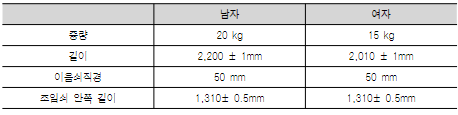

('{\n'
 '  "남자": {\n'
 '    "중량": "20 kg",\n'
 '    "길이": "2,200 ± 1mm",\n'
 '    "이름쇠직경": "50 mm",\n'
 '    "조임쇠 안쪽 길이": "1,310± 0.5mm"\n'
 '  },\n'
 '  "여자": {\n'
 '    "중량": "15 kg",\n'
 '    "길이": "2,010 ± 1mm",\n'
 '    "이름쇠직경": "50 mm",\n'
 '    "조임쇠 안쪽 길이": "1,310± 0.5mm"\n'
 '  }\n'
 '}')
input: 135,  0.00034$, 0원
output: 763,  0.00763$, 11원


In [16]:
base_dataset[4]['table_json'] = draw_result(base_dataset[4], 'gpt-4o')

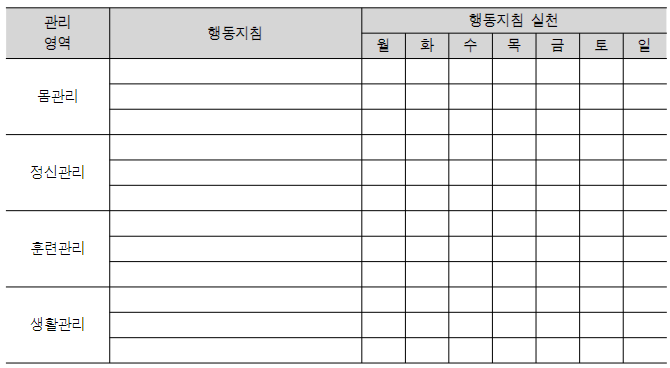

('{\n'
 '  "관리영역": [\n'
 '    {\n'
 '      "name": "몸관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "name": "정신관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "name": "훈련관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "name": "생활관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\

In [18]:
base_dataset[3]['table_json'] = draw_result(base_dataset[3], 'gpt-4o')

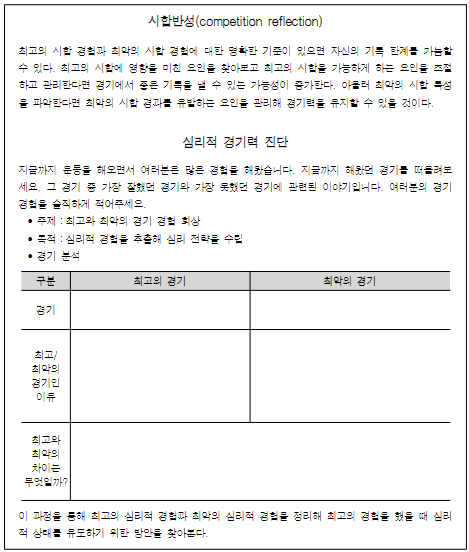

('{\n'
 '  "title": "시험반성(competition reflection)",\n'
 '  "introduction": "최고의 시합 경험과 최악의 시합 경험에 대한 명확한 기준이 있으면 자신의 기록 경계를 기할 수 있다. '
 '최고의 시합에 영향을 미리 오르며 찾아오는 최고의 시합을 가능하게 하며 오르며 긍정하고 최악의 시합에선 좋은 기록을 낼 수 있는 가능성이 '
 '높아진다. 최고의 시합과 최악의 시합 경험을 파악한다면 최악의 시합 경험을 뒤바라는 요인을 파악하여 경기를 유지할 수 있을 것이다.",\n'
 '  "section": "심리적 경기력 진단",\n'
 '  "description": "지금까지 훈련을 해오면서 여러분은 많은 경기를 해왔습니다. 지금까지 해왔던 경기를 떠올려 보세요. 그 '
 '경기가 가장 좋았던 경기와 가장 못했던 경기에 대해 구체적인 이야기를 해봅시다. 여러분의 경기 경험을 상세히 적어봅시다.",\n'
 '  "subsections": [\n'
 '    "주제 : 경기력 향상과 경기 경험 심상",\n'
 '    "목적 : 심리적 경기를 추측해 경기력을 수반",\n'
 '    "경기 분석"\n'
 '  ],\n'
 '  "table": {\n'
 '    "headers": ["구분", "최고의 경기", "최악의 경기"],\n'
 '    "rows": [\n'
 '      {\n'
 '        "구분": "경기",\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      {\n'
 '        "구분": "최고/최악의 경기 이유",\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      {\n'
 '        "구분": "최고와 최악의 공통점은 무엇인가?",\n'
 '        "최고의 경기": "",\n'
 '       

In [19]:
base_dataset[2]['table_json'] = draw_result(base_dataset[2], 'gpt-4o')

In [9]:
base_dataset[1]['table_json'] = draw_result(base_dataset[1], 'gpt-4o')

NameError: name 'draw_result' is not defined

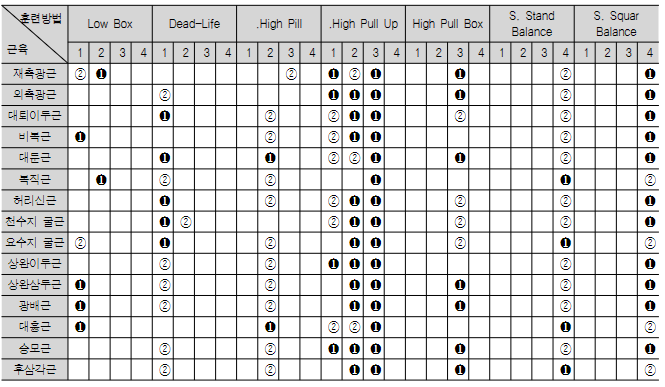

('{\n'
 '  "훈련방법": {\n'
 '    "Low Box": {\n'
 '      "1": {\n'
 '        "저측광근": "②",\n'
 '        "외측광근": "",\n'
 '        "대퇴이두근": "",\n'
 '        "비복근": "①",\n'
 '        "대흉근": "",\n'
 '        "특정근": "",\n'
 '        "허리신근": "",\n'
 '        "척추기립근": "",\n'
 '        "오수지굴근": "",\n'
 '        "상완이두근": "",\n'
 '        "상완삼두근": "",\n'
 '        "광배근": "①",\n'
 '        "송근": "",\n'
 '        "추상근": ""\n'
 '      },\n'
 '      "2": {\n'
 '        "저측광근": "",\n'
 '        "외측광근": "",\n'
 '        "대퇴이두근": "",\n'
 '        "비복근": "",\n'
 '        "대흉근": "",\n'
 '        "특정근": "",\n'
 '        "허리신근": "",\n'
 '        "척추기립근": "",\n'
 '        "오수지굴근": "",\n'
 '        "상완이두근": "",\n'
 '        "상완삼두근": "",\n'
 '        "광배근": "",\n'
 '        "송근": "",\n'
 '        "추상근": ""\n'
 '      },\n'
 '      "3": {\n'
 '        "저측광근": "",\n'
 '        "외측광근": "",\n'
 '        "대퇴이두근": "",\n'
 '        "비복근": "",\n'
 '        "대흉근": "",\n'
 '        "특정근": "",\n'
 '        "허리신근": "",\n'
 '

In [21]:
base_dataset[0]['table_json'] = draw_result(base_dataset[0], 'gpt-4o')

In [27]:
import pickle

# with open('../data/experiment/informationExtract/table/information/table_dataset.pickle', 'wb') as f:
#     pickle.dump(base_dataset, f)

##### gpt-4o-mini

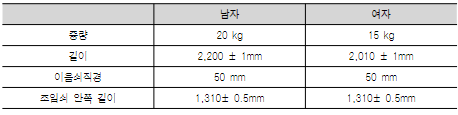

('{\n'
 '  "테이블": {\n'
 '    "남자": {\n'
 '      "품량": "20 kg",\n'
 '      "길이": "2,200 ± 1 mm",\n'
 '      "이름식적정": "50 mm",\n'
 '      "조의식 안쪽 길이": "1,310 ± 0.5 mm"\n'
 '    },\n'
 '    "여자": {\n'
 '      "품량": "15 kg",\n'
 '      "길이": "2,010 ± 1 mm",\n'
 '      "이름식적정": "50 mm",\n'
 '      "조의식 안쪽 길이": "1,310 ± 0.5 mm"\n'
 '    }\n'
 '  }\n'
 '}')
input: 139,  0.00209$, 3원
output: 8693,  0.52158$, 751원


In [42]:
draw_result(base_dataset[4], 'gpt-4o-mini')

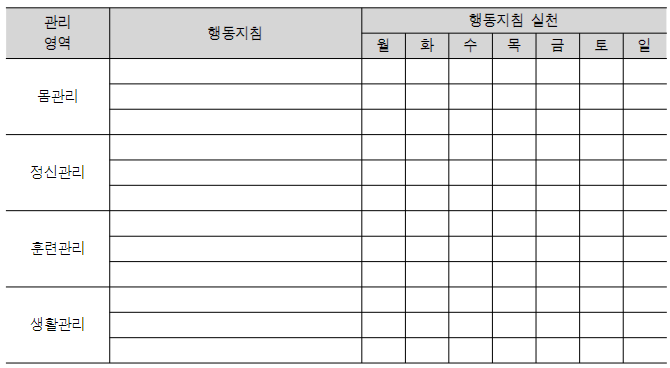

('{\n'
 '  "관리영역": [\n'
 '    {\n'
 '      "행동지침": "몸관리",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "행동지침": "정신관리",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "행동지침": "훈련관리",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "행동지침": "생활관리",\n'
 '      "행동지침실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    }\n'
 '  ]\n'
 '}')
input: 

In [43]:
draw_result(base_dataset[3], 'gpt-4o-mini')

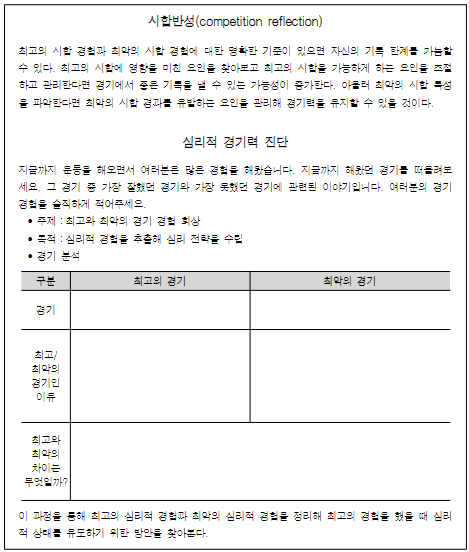

('{\n'
 '  "테이블": {\n'
 '    "구분": [\n'
 '      {\n'
 '        "항목": "경기",\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      {\n'
 '        "항목": "최고/최악의 이유": "",\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      {\n'
 '        "항목": "경기 분석": "",\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      }\n'
 '    ]\n'
 '  }\n'
 '}')
input: 114,  0.00171$, 2원
output: 14360,  0.8616$, 1241원


In [44]:
draw_result(base_dataset[2], 'gpt-4o-mini')

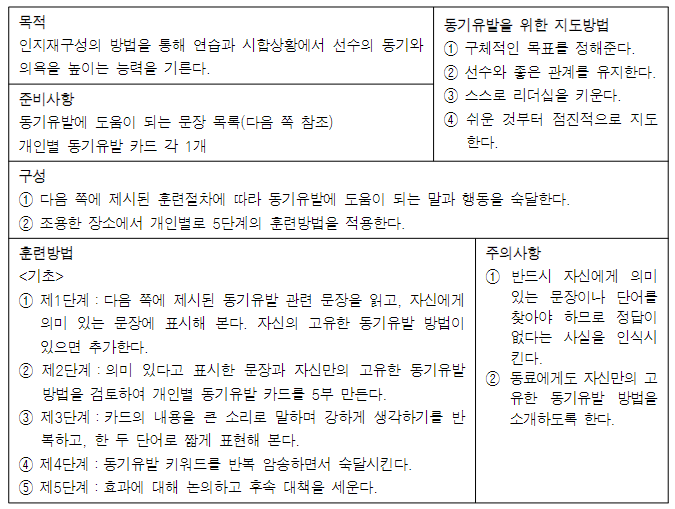

('{\n'
 '  "목적": "인지재구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 외적을 높이는 능력을 기른다.",\n'
 '  "동기유발을 위한 지도방법": {\n'
 '    "구체적인 목표를 정해준다.": null,\n'
 '    "선수와 좋은 관계를 유지한다.": null,\n'
 '    "소스로 리더십을 키운다.": null,\n'
 '    "쉬운 것부터 점진적으로 지도한다.": null\n'
 '  },\n'
 '  "준비사항": {\n'
 '    "동기유발에 도움이 되는 문장 목록": "다음 쪽 참조",\n'
 '    "개별 동기유발 카드": "각 1개"\n'
 '  },\n'
 '  "구성": {\n'
 '    "훈련방법": {\n'
 '      "1단계": [\n'
 '        "다음 쪽에 제시된 동기유발 관련 문장을 읽고, 자신에게 있는 감정을 표시해 본다.",\n'
 '        "자신의 고유한 동기유발 방법을 정리한다."\n'
 '      ],\n'
 '      "2단계": [\n'
 '        "이 문장이 있고나서 표현된 감정과 자신의 고유한 동기유발 방법을 비교하여 동기유발 카드를 5개 만든다."\n'
 '      ],\n'
 '      "3단계": [\n'
 '        "카드를 정리하여 동기유발 카드를 5개 만든다."\n'
 '      ],\n'
 '      "4단계": [\n'
 '        "효과에 대해 느끼는 것과 추후 대체를 세운다."\n'
 '      ]\n'
 '    }\n'
 '  },\n'
 '  "주의사항": [\n'
 '    "반드시 자신에 의미 있는 문장이나 단어를 사용하여 동기유발을 해야 한다.",\n'
 '    "이 문장에서 제시되는 고유한 동기유발 방법을 사람을 인식시킨다."\n'
 '  ]\n'
 '}')
input: 392,  0.00588$, 8원
output: 14360,  0.8616$, 1241원


In [45]:
draw_result(base_dataset[1], 'gpt-4o-mini')

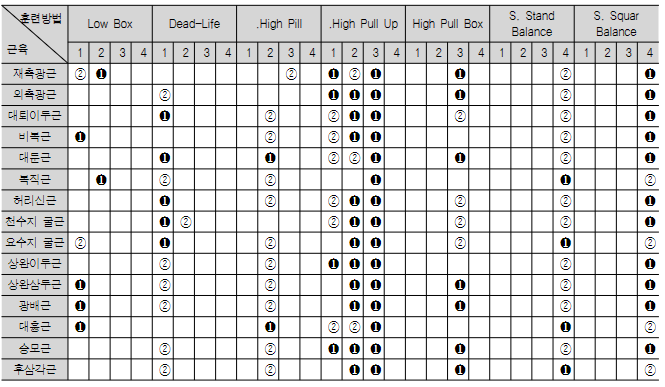

('{\n'
 '  "훈련방법": {\n'
 '    "근육": [\n'
 '      {\n'
 '        "이름": "저축항근",\n'
 '        "Low Box": [2, 1, 1, 1],\n'
 '        "Dead-Life": [0, 0, 0, 0],\n'
 '        "High Pill": [0, 0, 0, 0],\n'
 '        "High Pull Up": [0, 0, 0, 0],\n'
 '        "High Pull Box": [0, 0, 0, 0],\n'
 '        "S. Stand Balance": [0, 0, 0, 0],\n'
 '        "S. Square Balance": [0, 0, 0, 0]\n'
 '      },\n'
 '      {\n'
 '        "이름": "외측광근",\n'
 '        "Low Box": [2, 1, 1, 1],\n'
 '        "Dead-Life": [0, 0, 0, 0],\n'
 '        "High Pill": [0, 0, 0, 0],\n'
 '        "High Pull Up": [0, 0, 0, 0],\n'
 '        "High Pull Box": [0, 0, 0, 0],\n'
 '        "S. Stand Balance": [0, 0, 0, 0],\n'
 '        "S. Square Balance": [0, 0, 0, 0]\n'
 '      },\n'
 '      {\n'
 '        "이름": "대퇴이두근",\n'
 '        "Low Box": [2, 1, 1, 1],\n'
 '        "Dead-Life": [0, 0, 0, 0],\n'
 '        "High Pill": [0, 0, 0, 0],\n'
 '        "High Pull Up": [0, 0, 0, 0],\n'
 '        "High Pull Box": [0, 0, 0, 0],\n'
 '     

In [46]:
draw_result(base_dataset[0], 'gpt-4o-mini')

### 표 제목 포함

In [9]:
def draw_result(data, model_name, prompt_path='../prompt/information_table/table_raw_20250311_01.yaml'):
    prompt = load_prompt(prompt_path)
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    llm = ChatOpenAI(model=model_name, temperature=0)
    chain = chat_prompt | llm

    base64_image, image_type = encode_image(data['image_path'])
    result = chain.invoke({'image_type': image_type,
                           'base64_image': base64_image,
                           'image_title': data['title']})

    display(Image(data['image_path']))
    pprint(result.content)
    printToken(result, model_name)

#### gpt-4o-mini

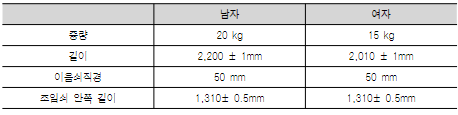

('{\n'
 '  "테이블": {\n'
 '    "헤더": {\n'
 '      "남자": ["품량", "길이", "이물식적정", "조의식 안쪽 길이"],\n'
 '      "여자": ["품량", "길이", "이물식적정", "조의식 안쪽 길이"]\n'
 '    },\n'
 '    "데이터": [\n'
 '      {\n'
 '        "남자": "20 kg",\n'
 '        "여자": "15 kg"\n'
 '      },\n'
 '      {\n'
 '        "남자": "2,200 ± 1 mm",\n'
 '        "여자": "2,010 ± 1 mm"\n'
 '      },\n'
 '      {\n'
 '        "남자": "50 mm",\n'
 '        "여자": "50 mm"\n'
 '      },\n'
 '      {\n'
 '        "남자": "1,310 ± 0.5 mm",\n'
 '        "여자": "1,310 ± 0.5 mm"\n'
 '      }\n'
 '    ]\n'
 '  }\n'
 '}')
input: 197,  3e-05$, 0원
output: 8789,  0.00527$, 8원


In [19]:
draw_result(base_dataset[4], 'gpt-4o-mini')

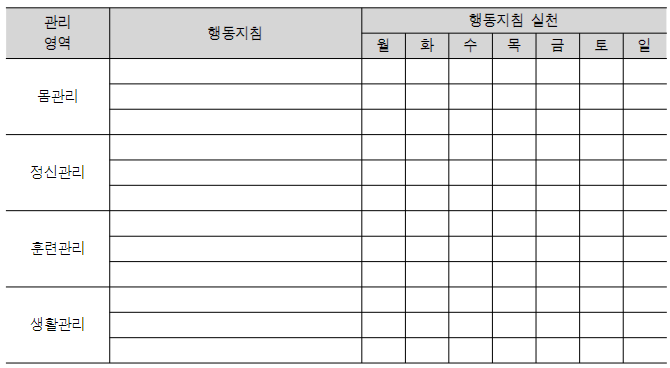

('{\n'
 '  "관리영역": {\n'
 '    "행동지침": {\n'
 '      "월": "",\n'
 '      "화": "",\n'
 '      "수": "",\n'
 '      "목": "",\n'
 '      "금": "",\n'
 '      "토": "",\n'
 '      "일": ""\n'
 '    },\n'
 '    "목관리": {\n'
 '      "행동지침": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    "정신관리": {\n'
 '      "행동지침": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    "훈련관리": {\n'
 '      "행동지침": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    "생활관리": {\n'
 '      "행동지침": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 ' 

In [20]:
draw_result(base_dataset[3], 'gpt-4o-mini')

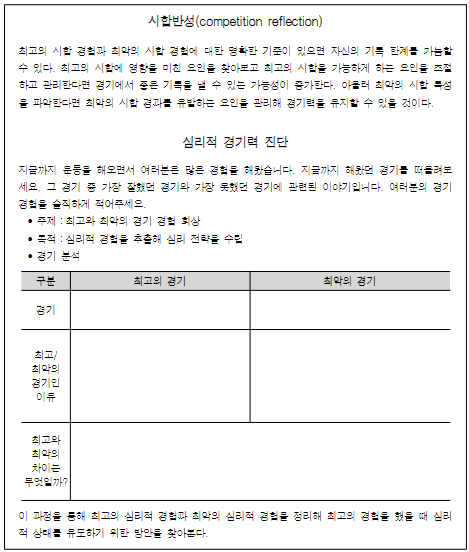

('{\n'
 '  "테이블": {\n'
 '    "제목": "시험반성(competiion reflection)",\n'
 '    "설명": "최고의 시합 경험과 최악의 시합 경험에 대한 반성적 기준이 있으며 자신의 기록을 가능하게 할 수 있다. 최고의 시합의 '
 '영향을 미리 오리엔트 할 수 있도록 시합이 가능하게 하며 오히려 긍정하고 피드백된 경험이 주는 기회를 살 수 있는 가능성이 있을 '
 '것이다.",\n'
 '    "구분": {\n'
 '      "최고의 경기": "",\n'
 '      "최악의 경기": ""\n'
 '    },\n'
 '    "행": [\n'
 '      {\n'
 '        "경기": "",\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      {\n'
 '        "최고/최악의 이유": "",\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      {\n'
 '        "최고의 경기와 부문": ""\n'
 '      }\n'
 '    ],\n'
 '    "부가설명": "이 과정을 통해 스포츠의 심리적 경험과 심리적 경기를 통해 경기를 발전시키는 방법을 스스로가 이해할 수 있는 '
 '방향을 찾아보자."\n'
 '  }\n'
 '}')
input: 255,  4e-05$, 0원
output: 14456,  0.00867$, 12원


In [21]:
draw_result(base_dataset[2], 'gpt-4o-mini')

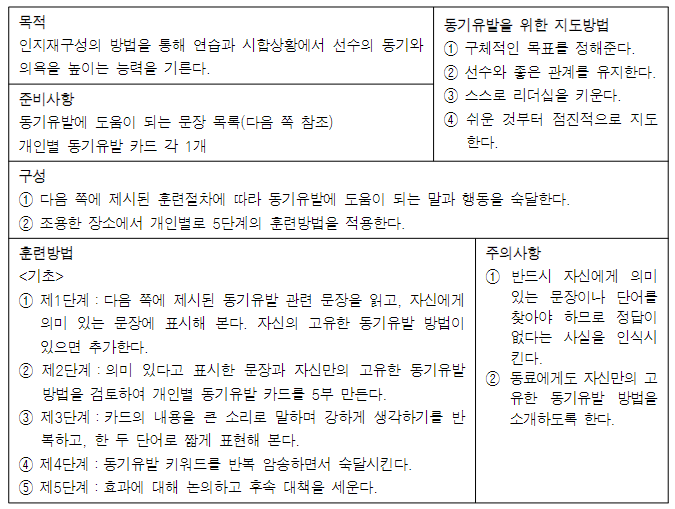

('{\n'
 '  "목적": "인지재구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 외적요인을 높이는 능력을 기른다.",\n'
 '  "동기유발을 위한 지도방법": {\n'
 '    "구체적인 목표를 정해준다.": null,\n'
 '    "선수와 좋은 관계를 유지한다.": null,\n'
 '    "소소한 리더십을 키운다.": null,\n'
 '    "쉬운 것부터 점진적으로 지도한다.": null\n'
 '  },\n'
 '  "준비사항": {\n'
 '    "동기유발에 도움이 되는 문장 목록": "다음 쪽 참조",\n'
 '    "개별 동기유발 카드": "각 1개"\n'
 '  },\n'
 '  "구성": {\n'
 '    "훈련방법": {\n'
 '      "1": {\n'
 '        "제1단계": "다음 쪽에 제시된 동기유발 관련 문장을 읽고, 자신에게 있는 동기와 표시해 본다. 자신의 유형과 동기유발 '
 '방법을 확인한다."\n'
 '      },\n'
 '      "2": {\n'
 '        "제2단계": "이해가 있다면 표현된 문장과 자신의 고유한 동기유발 방법을 연결하여 동기유발 카드를 5개 만든다."\n'
 '      },\n'
 '      "3": {\n'
 '        "제3단계": "효과에 대해 느끼는 것과 추후 대체를 세운다."\n'
 '      }\n'
 '    }\n'
 '  },\n'
 '  "주요사항": {\n'
 '    "1": "반드시 자신의 의미 있는 문장이나 단어를 사용하여 동기유발을 해야 한다.",\n'
 '    "2": "이해가 되지 않는 경우에는 고유한 사람을 인식시킨다."\n'
 '  }\n'
 '}')
input: 374,  6e-05$, 0원
output: 14456,  0.00867$, 12원


In [22]:
draw_result(base_dataset[1], 'gpt-4o-mini')

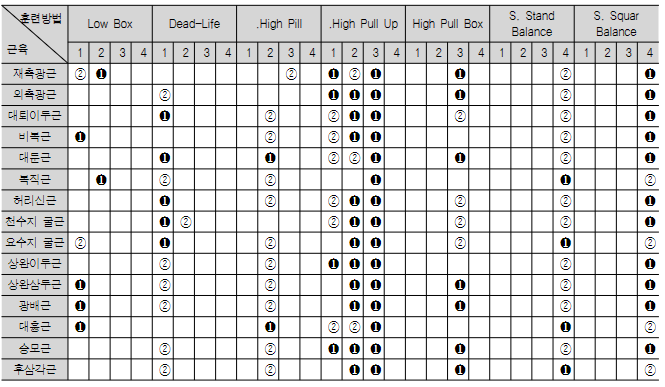

('{\n'
 '  "표": {\n'
 '    "초련방법": {\n'
 '      "근육": [\n'
 '        "저축항근",\n'
 '        "외측광근",\n'
 '        "대퇴이두근",\n'
 '        "비복근",\n'
 '        "대둔근",\n'
 '        "복직근",\n'
 '        "허리근육",\n'
 '        "천측근",\n'
 '        "오수지근",\n'
 '        "상완이두근",\n'
 '        "상완삼두근",\n'
 '        "광배근",\n'
 '        "대흉근",\n'
 '        "승모근",\n'
 '        "추측근"\n'
 '      ]\n'
 '    },\n'
 '    "운동": {\n'
 '      "Low Box": {\n'
 '        "1": "②",\n'
 '        "2": "①",\n'
 '        "3": "①",\n'
 '        "4": "①"\n'
 '      },\n'
 '      "Dead-Life": {\n'
 '        "1": "①",\n'
 '        "2": "②",\n'
 '        "3": "①",\n'
 '        "4": "①"\n'
 '      },\n'
 '      "High Pill": {\n'
 '        "1": "①",\n'
 '        "2": "②",\n'
 '        "3": "①",\n'
 '        "4": "①"\n'
 '      },\n'
 '      "High Pull Up": {\n'
 '        "1": "①",\n'
 '        "2": "②",\n'
 '        "3": "①",\n'
 '        "4": "①"\n'
 '      },\n'
 '      "High Pull Box": {\n'
 '        "1": "①",\n'
 '        "2

In [23]:
draw_result(base_dataset[0], 'gpt-4o-mini')

#### gpt-4o

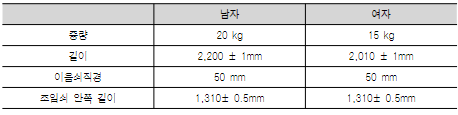

('{\n'
 '  "품목": [\n'
 '    {\n'
 '      "항목": "중량",\n'
 '      "남자": "20 kg",\n'
 '      "여자": "15 kg"\n'
 '    },\n'
 '    {\n'
 '      "항목": "길이",\n'
 '      "남자": "2,200 ± 1mm",\n'
 '      "여자": "2,010 ± 1mm"\n'
 '    },\n'
 '    {\n'
 '      "항목": "이륜식직경",\n'
 '      "남자": "50 mm",\n'
 '      "여자": "50 mm"\n'
 '    },\n'
 '    {\n'
 '      "항목": "조립식 안쪽 길이",\n'
 '      "남자": "1,310± 0.5mm",\n'
 '      "여자": "1,310± 0.5mm"\n'
 '    }\n'
 '  ]\n'
 '}')
input: 168,  0.00042$, 1원
output: 544,  0.00544$, 8원


In [26]:
draw_result(base_dataset[4], 'gpt-4o')

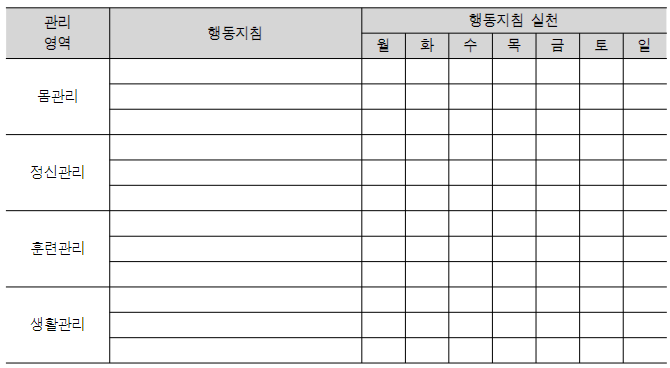

('{\n'
 '  "관리 영역": [\n'
 '    {\n'
 '      "영역": "몸관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침 실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "영역": "정신관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침 실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "영역": "훈련관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침 실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'
 '        "토": "",\n'
 '        "일": ""\n'
 '      }\n'
 '    },\n'
 '    {\n'
 '      "영역": "생활관리",\n'
 '      "행동지침": "",\n'
 '      "행동지침 실천": {\n'
 '        "월": "",\n'
 '        "화": "",\n'
 '        "수": "",\n'
 '        "목": "",\n'
 '        "금": "",\n'


In [27]:
draw_result(base_dataset[3], 'gpt-4o')

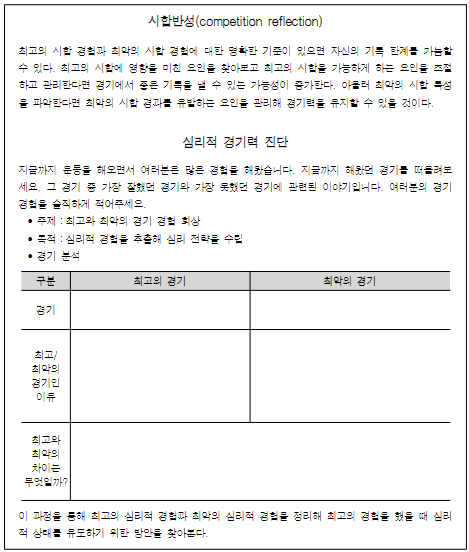

('{\n'
 '  "표제": "시험반성(competition reflection)",\n'
 '  "설명": "최고의 시합 경험과 최악의 시합 경험에 대한 명확한 기준이 있으면 자신의 기록 경지를 가늠할 수 있다. 최고의 시합에 '
 '영향을 미리 요인들 찾아보고 최고의 시합을 가능하게 해준 요인을 강화하고 최악의 시합이었던 경기에서 좋은 기록을 낼 수 있는 가능성이 '
 '있었는지를 찾아본다. 최고의 시합 경험을 파악한다면 최악의 시합 경험을 뒤바꿀 수 있는 요인을 파악하여 경기를 유지할 수 있을 '
 '것이다.",\n'
 '  "심리적 경기력 진단": {\n'
 '    "설명": "지금까지 훈련을 해오면서 여러분은 많은 경기를 해왔습니다. 지금까지 해왔던 경기를 떠올려 보세요. 그 경기가 가장 '
 '좋았던 경기와 가장 못했던 경기에 관해 구체적인 이야기를 해봅시다. 여러분의 경기 경험을 상세히 적어봅시다.",\n'
 '    "목적": [\n'
 '      "최고의 시합과 최악의 시합 경험 심상",\n'
 '      "목적 : 심리적 경감을 촉진하여 경기력을 수반",\n'
 '      "경기 분석"\n'
 '    ]\n'
 '  },\n'
 '  "표": {\n'
 '    "구분": {\n'
 '      "경기": {\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      "최고/최악의 경기 이유": {\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      },\n'
 '      "최고와 최악의 공통점은 무엇인가?": {\n'
 '        "최고의 경기": "",\n'
 '        "최악의 경기": ""\n'
 '      }\n'
 '    }\n'
 '  },\n'
 '  "결론": "이 과정을 통해 최고의 심리적 경기력을 강화하여 심리적 경험을 통해 최고의 경력을 쌓을 수 있는 최

In [10]:
draw_result(base_dataset[2], 'gpt-4o')

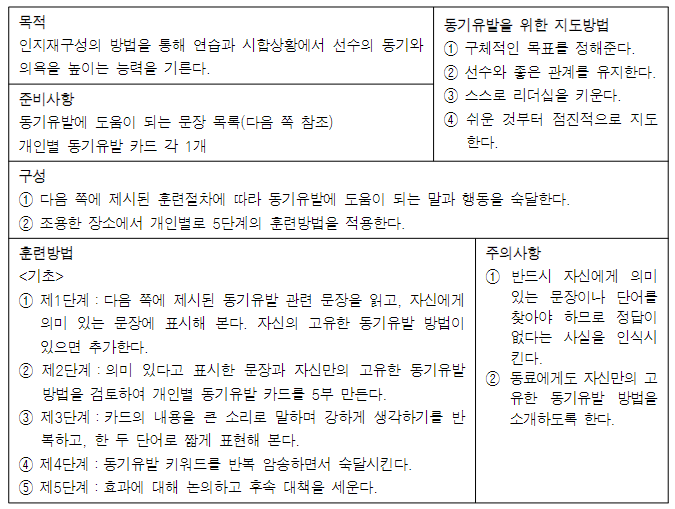

('{\n'
 '  "목적": "인지재구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기른다.",\n'
 '  "준비사항": [\n'
 '    "동기유발에 도움이 되는 문장 목록(다음 쪽 참조)",\n'
 '    "개인별 동기유발 카드 각 1개"\n'
 '  ],\n'
 '  "구성": [\n'
 '    "다음 쪽에 제시된 훈련절차에 따라 동기유발에 도움이 되는 말과 행동을 숙달한다.",\n'
 '    "훈련장소에서 개인별로 5단계의 훈련방법을 적용한다."\n'
 '  ],\n'
 '  "훈련방법": {\n'
 '    "제1단계": [\n'
 '      "다음 쪽에 제시된 동기유발 관련 문장을 읽고, 자신에게 의미 있는 문장을 표시해 본다. 자신의 고유한 동기유발 방법의 '
 '중요성을 인식시킨다."\n'
 '    ],\n'
 '    "제2단계": [\n'
 '      "의미 있다고 표시한 문장과 자신만의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 5개 만든다."\n'
 '    ],\n'
 '    "제3단계": [\n'
 '      "훈련장소에서 동기유발 카드를 사용하여 긍정적 생각과 행동을 반복적으로 연습한다."\n'
 '    ],\n'
 '    "제4단계": [\n'
 '      "훈련장소에서 훈련 내용을 반복하면서 숙달시킨다."\n'
 '    ],\n'
 '    "제5단계": [\n'
 '      "효과에 대해 논의하고 추후 대책을 세운다."\n'
 '    ]\n'
 '  },\n'
 '  "동기유발을 위한 지도방법": [\n'
 '    "구체적인 목표를 정해준다.",\n'
 '    "선수와 좋은 관계를 유지한다.",\n'
 '    "스스로 리더십을 키운다.",\n'
 '    "쉬운 것부터 점진적으로 지도한다."\n'
 '  ],\n'
 '  "주의사항": [\n'
 '    "반드시 자신에게 의미 있는 문장이나 단어를 사용하도록 하여 동기유발 방법의 중요성을 인식시킨다.",

In [29]:
draw_result(base_dataset[1], 'gpt-4o')

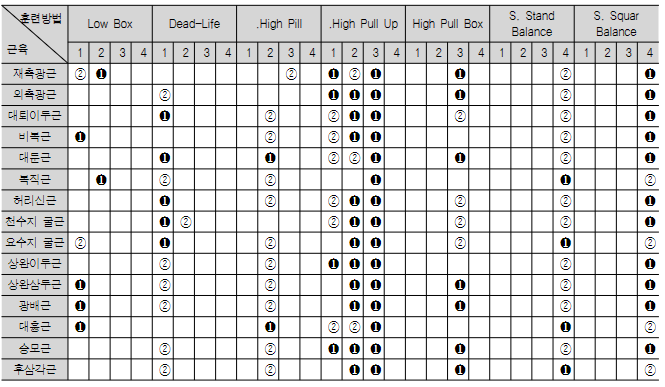

('{\n'
 '  "훈련방법": {\n'
 '    "근육": {\n'
 '      "저측광근": {\n'
 '        "Low Box": {\n'
 '          "1": "②",\n'
 '          "2": "",\n'
 '          "3": "",\n'
 '          "4": ""\n'
 '        },\n'
 '        "Dead-Life": {\n'
 '          "1": "",\n'
 '          "2": "",\n'
 '          "3": "",\n'
 '          "4": "①"\n'
 '        },\n'
 '        "High Pill": {\n'
 '          "1": "",\n'
 '          "2": "",\n'
 '          "3": "",\n'
 '          "4": ""\n'
 '        },\n'
 '        "High Pull Up": {\n'
 '          "1": "",\n'
 '          "2": "",\n'
 '          "3": "",\n'
 '          "4": ""\n'
 '        },\n'
 '        "High Pull Box": {\n'
 '          "1": "",\n'
 '          "2": "",\n'
 '          "3": "",\n'
 '          "4": ""\n'
 '        },\n'
 '        "S. Stand Balance": {\n'
 '          "1": "",\n'
 '          "2": "",\n'
 '          "3": "",\n'
 '          "4": ""\n'
 '        },\n'
 '        "S. Squar Balance": {\n'
 '          "1": "",\n'
 '          "2": "",\n'
 '     

In [30]:
draw_result(base_dataset[0], 'gpt-4o')

###

### 이미지 크기 전처리 기반 변환 실험
* 이미지 크기를 변형하여, 정보 복잡도가 높은 이미지 변환 실험
* 결과는 해결하지 못함

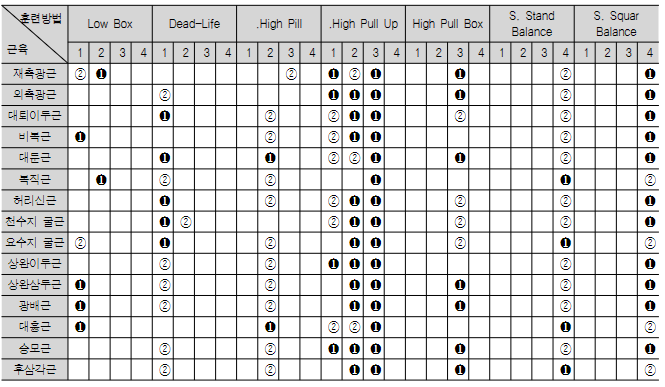

('{\n'
 '  "훈련방법": {\n'
 '    "Low Box": {\n'
 '      "1": {\n'
 '        "저측장근": "②",\n'
 '        "외측장근": "",\n'
 '        "대퇴이두근": "",\n'
 '        "비복근": "①",\n'
 '        "대흉근": "",\n'
 '        "특정근": "",\n'
 '        "허리신근": "",\n'
 '        "척수기립근": "",\n'
 '        "오수지굴근": "",\n'
 '        "상방이두근": "",\n'
 '        "상방삼두근": "",\n'
 '        "광배근": "①",\n'
 '        "송근": "",\n'
 '        "추상근": ""\n'
 '      },\n'
 '      "2": {\n'
 '        "저측장근": "",\n'
 '        "외측장근": "",\n'
 '        "대퇴이두근": "",\n'
 '        "비복근": "",\n'
 '        "대흉근": "",\n'
 '        "특정근": "",\n'
 '        "허리신근": "",\n'
 '        "척수기립근": "",\n'
 '        "오수지굴근": "",\n'
 '        "상방이두근": "",\n'
 '        "상방삼두근": "",\n'
 '        "광배근": "",\n'
 '        "송근": "",\n'
 '        "추상근": ""\n'
 '      },\n'
 '      "3": {\n'
 '        "저측장근": "",\n'
 '        "외측장근": "",\n'
 '        "대퇴이두근": "",\n'
 '        "비복근": "",\n'
 '        "대흉근": "",\n'
 '        "특정근": "",\n'
 '        "허리신근": "",\n'
 '

In [40]:
draw_result(base_dataset[0], 'gpt-4o')

In [ ]:
def get_image_resolution(image_path):
    # 이미지 파일 열기
    img = Image.open(image_path)
    
    # 이미지 크기(너비, 높이) 가져오기
    width, height = img.size
    
    # 파일 크기 확인 (바이트 단위)
    file_size_bytes = image_path.stat().st_size
    file_size_kb = file_size_bytes / 1024
    
    print(f"이미지 해상도: {width} x {height} 픽셀")
    print(f"파일 크기: {file_size_kb:.2f} KB")
    
    return width, height, file_size_kb

# 사용 예시
from pathlib import Path
image_path = Path(base_dataset[0]['image_path'])
resolution = get_image_resolution(image_path)

이미지 해상도: 665 x 387 픽셀
파일 크기: 55.52 KB


In [58]:
def resize_image(image_path, target_size=2048):
    """
    이미지 비율을 유지하면서 크기만 변경하는 간단한 함수
    
    Args:
        image_path (str): 원본 이미지 경로
        target_size (int): 긴 쪽을 맞출 크기 (기본값: 2048px)
        save_path (str): 저장할 경로 (None이면 저장하지 않고 이미지 객체만 반환)
    
    Returns:
        PIL.Image.Image: 변환된 이미지 객체
    """
    # 이미지 열기
    img = Image.open(image_path)
    
    # 원본 크기 및 비율 확인
    width, height = img.size
    aspect_ratio = width / height
    
    # 가로가 더 긴 경우
    if width >= height:
        new_width = target_size
        new_height = int(new_width / aspect_ratio)
    # 세로가 더 긴 경우
    else:
        new_height = target_size
        new_width = int(new_height * aspect_ratio)
    
    # 크기 변경
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)
    
    # 변경 정보 출력
    print(f"원본 크기: {width} x {height} 픽셀")
    print(f"변경 크기: {new_width} x {new_height} 픽셀")
    
    # 저장 옵션이 있는 경우
    save_path = image_path.replace('.png', '_resized.png')
    resized_img.save(save_path)
    print(f"이미지 저장 완료: {save_path}")
    
    # 변형된 이미지 반환
    return save_path

In [59]:
resized_path = resize_image(base_dataset[0]['image_path'], )

원본 크기: 665 x 387 픽셀
변경 크기: 2048 x 1191 픽셀
이미지 저장 완료: ../data/experiment/informationExtract/table/information/information_1_resized.png


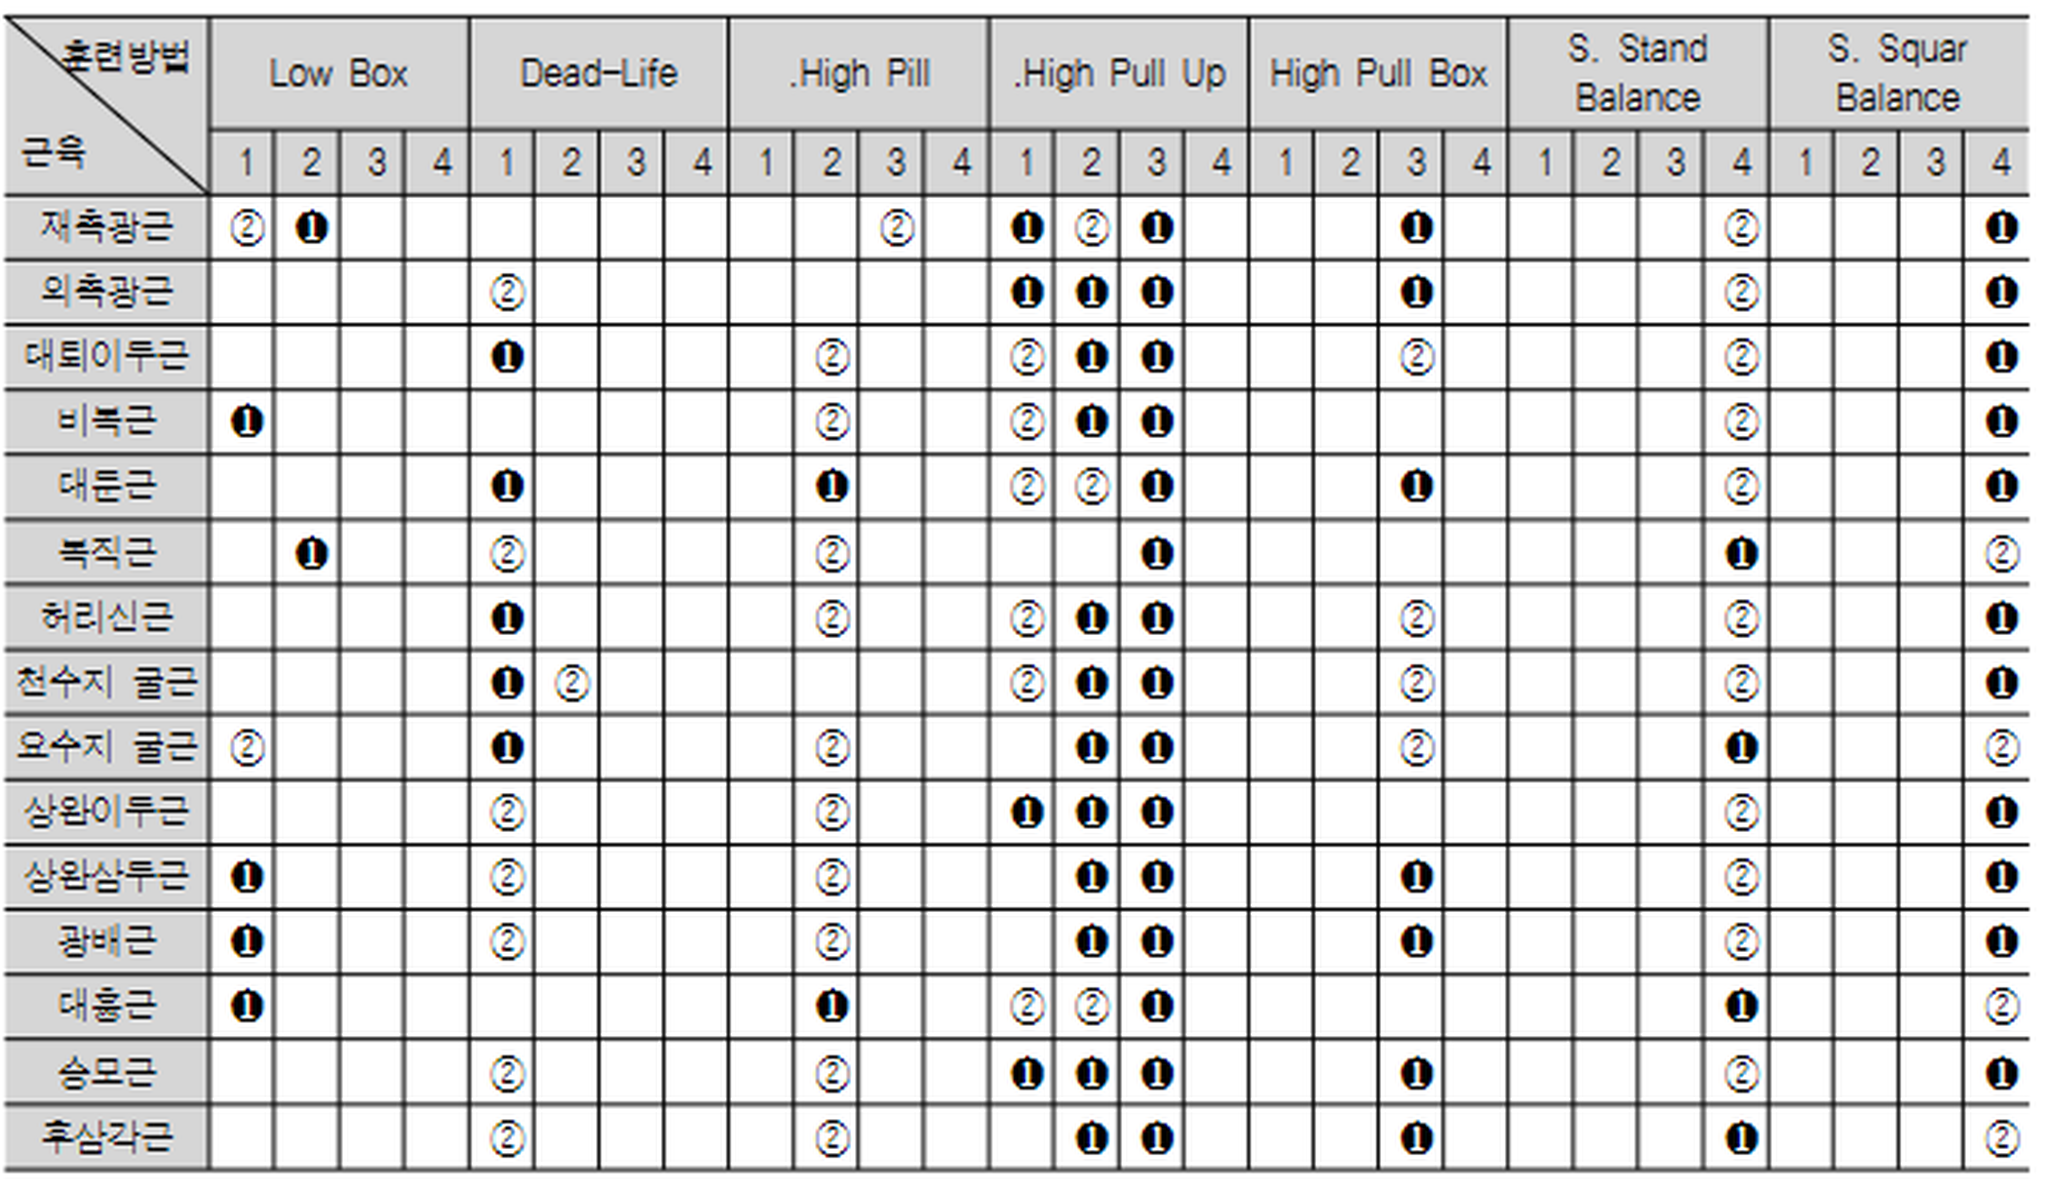

In [57]:
resized_image

In [50]:
def draw_result(image_path, model_name, prompt_path='../prompt/information_table/table_raw_20250312_01.yaml'):
    prompt = load_prompt(prompt_path)
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    llm = ChatOpenAI(model=model_name, temperature=0)
    chain = chat_prompt | llm

    base64_image, image_type = encode_image(image_path)
    result = chain.invoke({'image_type': image_type,
                           'base64_image': base64_image})
    # display(image)
    pprint(result.content)
    printToken(result, model_name)

In [60]:
draw_result(resized_path, 'gpt-4o')

('{\n'
 '  "훈련방법": {\n'
 '    "Low Box": {\n'
 '      "1": {\n'
 '        "저측광근": "②",\n'
 '        "비복근": "①",\n'
 '        "오수지 굴근": "②",\n'
 '        "상완삼두근": "①",\n'
 '        "광배근": "①",\n'
 '        "대흉근": "①"\n'
 '      },\n'
 '      "2": {\n'
 '        "저측광근": "①",\n'
 '        "비복근": "①",\n'
 '        "상완이두근": "②",\n'
 '        "상완삼두근": "②",\n'
 '        "광배근": "②",\n'
 '        "대흉근": "②",\n'
 '        "승모근": "②"\n'
 '      },\n'
 '      "3": {\n'
 '        "상완이두근": "②",\n'
 '        "상완삼두근": "②",\n'
 '        "광배근": "②",\n'
 '        "대흉근": "②",\n'
 '        "승모근": "②"\n'
 '      },\n'
 '      "4": {\n'
 '        "상완이두근": "②",\n'
 '        "상완삼두근": "②",\n'
 '        "광배근": "②",\n'
 '        "대흉근": "②",\n'
 '        "승모근": "②"\n'
 '      }\n'
 '    },\n'
 '    "Dead-Life": {\n'
 '      "1": {\n'
 '        "의측광근": "②",\n'
 '        "천수지 굴근": "①",\n'
 '        "상완이두근": "①",\n'
 '        "상완삼두근": "①",\n'
 '        "광배근": "①",\n'
 '        "대흉근": "①"\n'
 '      },\n'
 '      "2":

## 정보 추출 실험

In [30]:
with open('../data/experiment/informationExtract/table/information/table_dataset.pickle', 'rb') as f:
    base_dataset = pickle.load(f)

In [35]:
base_dataset

[{'image_path': '../data/experiment/informationExtract/table/information/information_1.png',
  'title': '표 5. 보조프로그램의 주동근 동원 순서',
  'context': '인상기술 향상을 위한 보조훈련의 효과검증 결과, 국면별(1~4국면) 보조프로그램들의 근육활용도가 표로 제시되어 있습니다. 특정 국면에서 특정 근육을 강화하기 위해 이 표를 참조하면 더 효과적인 훈련이 가능합니다.',
  'description': '정보 복잡도 높음',
  'table_json': '{\n  "훈련방법": {\n    "Low Box": {\n      "1": {\n        "저측광근": "②",\n        "외측광근": "",\n        "대퇴이두근": "",\n        "비복근": "①",\n        "대흉근": "",\n        "특정근": "",\n        "허리신근": "",\n        "척추기립근": "",\n        "오수지굴근": "",\n        "상완이두근": "",\n        "상완삼두근": "",\n        "광배근": "①",\n        "송근": "",\n        "추상근": ""\n      },\n      "2": {\n        "저측광근": "",\n        "외측광근": "",\n        "대퇴이두근": "",\n        "비복근": "",\n        "대흉근": "",\n        "특정근": "",\n        "허리신근": "",\n        "척추기립근": "",\n        "오수지굴근": "",\n        "상완이두근": "",\n        "상완삼두근": "",\n        "광배근": "",\n        "송근": "",\n        "추상근": ""\n      },\n      "3": {\n       

In [8]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

class TableInformationExtract(BaseModel):
    detail: str = Field(description='key insights and information visible in the TABLE')
    entity: List[str] = Field(description="significant entities or objects in TABLE")
    hypotheticalQuestions: List[str] = Field(description="relevant hypothetical questions")    

parser = PydanticOutputParser(pydantic_object=TableInformationExtract)

In [41]:
def draw_result(data, model_name, prompt_path, parser):
    prompt = load_prompt(prompt_path)
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    chat_prompt = chat_prompt.partial(language='KOREAN',format=parser.get_format_instructions())

    llm = ChatOpenAI(model=model_name, temperature=0)
    chain = chat_prompt | llm

    result = chain.invoke({
        'table_json': data['table_json'],
        'title': data['title'],
        'context': data['context']
    })
    print(data['title'])
    print(data['table_json'])
    print(data['context'])

    print("\n\n--------------------------------\n\n")
    result_parse = parser.parse(result.content)

    print(f"detail: {result_parse.detail}")
    print(f"entity: {result_parse.entity}")
    print(f"hypotheticalQuestions: {result_parse.hypotheticalQuestions}")
    print("\n\n--------------------------------\n\n")

    printToken(result, model_name)
    print("\n\n--------------------------------\n\n")

    return result
       

### key instruction 미포함 프롬프트

#### gpt-4o-mini

In [42]:
draw_result(base_dataset[0], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 5. 보조프로그램의 주동근 동원 순서
{
  "훈련방법": {
    "Low Box": {
      "1": {
        "저측광근": "②",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "①",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "①",
        "송근": "",
        "추상근": ""
      },
      "2": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "3": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "4": {
        "저측광근": "",
        "외측광근

AIMessage(content='```json\n{\n  "detail": "표 5는 보조프로그램의 주동근 동원 순서를 나타내고 있으며, \'Low Box\' 훈련 방법에서 1국면에서 비복근과 광배근이 가장 많이 활용되었음을 보여줍니다. 비복근과 광배근은 각각 ①로 표시되어 있으며, 저측광근은 ②로 표시되어 있습니다. 다른 훈련 방법이나 국면에서는 특정 근육의 활용도가 표시되지 않았습니다.",\n  "entity": [\n    "Low Box",\n    "Dead-Life",\n    "High Pill",\n    "High Pull Up",\n    "High Pull Box",\n    "S. Stand Balance",\n    "S. Squar Balance",\n    "저측광근",\n    "외측광근",\n    "대퇴이두근",\n    "비복근",\n    "대흉근",\n    "특정근",\n    "허리신근",\n    "척추기립근",\n    "오수지굴근",\n    "상완이두근",\n    "상완삼두근",\n    "광배근",\n    "송근",\n    "추상근"\n  ],\n  "hypotheticalQuestions": [\n    "왜 \'Low Box\' 훈련 방법에서만 특정 근육이 활성화되었을까?",\n    "다른 훈련 방법에서도 특정 근육을 활성화할 수 있는 방법은 무엇일까?",\n    "비복근과 광배근의 활성화가 다른 국면에서도 중요한 역할을 할 수 있을까?",\n    "저측광근의 활성화가 1국면에서만 나타나는 이유는 무엇일까?",\n    "다른 국면에서 근육 활성화가 나타나지 않은 이유는 무엇일까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 389, 'prompt_tokens': 3949, 'total_tokens': 4338, 'completion_tokens_

In [43]:
draw_result(base_dataset[1], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 8. 동기유발 훈련방법
{
  "목적": "인지재구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기른다.",
  "준비사항": {
    "문장목록": "동기유발에 도움이 되는 문장 목록(다음 쪽 참조)",
    "카드": "개인별 동기유발 카드 각 1개"
  },
  "구성": [
    "다음 쪽에 제시된 훈련절차에 따라 동기유발에 도움이 되는 말과 행동을 숙달한다.",
    "훈련절차에 제시된 개인별로 5단계의 훈련방법을 적용한다."
  ],
  "훈련방법": {
    "1단계": "다음 쪽에 제시된 동기유발 관련 문장을 읽고, 자신에게 의미 있는 문장을 표시해 본다. 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "2단계": "의미 있다고 표시한 문장과 자신만의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 5개 만든다.",
    "3단계": "훈련절차에 따라 동기유발 카드를 활용하여 생각하기를 반복한다.",
    "4단계": "훈련절차에 따라 훈련을 반복하면서 숙달시킨다.",
    "5단계": "효과에 대해 논의하고 추후 대책을 세운다."
  },
  "동기유발을 위한 지도방법": [
    "구체적인 목표를 정해준다.",
    "선수와 좋은 관계를 유지한다.",
    "스스로 리더십을 키운다.",
    "쉬운 것부터 점진적으로 지도한다."
  ],
  "주의사항": [
    "반드시 자신에게 의미 있는 문장이나 단어를 선택하도록 하여 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "훈련절차에 제시된 자신의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 만든다."
  ]
}
우수한 역도 선수의 특징 중 하나는 높은 의욕과 동기입니다. 동기는 목표 달성을 위한 노력의 정도와 관련되며, 우수한 선수로 성장하는 데 중요한 요소이므로 지도자는 선수의 동기 강화와 적극적 참여 방법에 관심을 가져야 합니다


-------------------------------

AIMessage(content='```json\n{\n  "detail": "이 훈련 방법은 선수의 동기와 의욕을 높이기 위해 인지재구성의 방법을 사용하며, 개인별 동기유발 카드를 통해 선수의 고유한 동기유발 방법을 개발하는 데 중점을 둡니다. 훈련은 5단계로 구성되어 있으며, 구체적인 목표 설정과 선수와의 관계 유지가 중요합니다.",\n  "entity": [\n    "동기유발 훈련방법",\n    "인지재구성",\n    "동기유발 카드",\n    "훈련절차",\n    "목표 설정",\n    "선수와의 관계"\n  ],\n  "hypotheticalQuestions": [\n    "선수의 동기와 의욕을 높이기 위해 어떤 추가적인 방법을 사용할 수 있을까?",\n    "개인별 동기유발 카드를 만드는 과정에서 선수들이 어떤 어려움을 겪을 수 있을까?",\n    "훈련 후 효과에 대한 논의는 어떻게 진행되어야 할까?",\n    "동기유발을 위한 지도방법 중 어떤 것이 가장 효과적일까?",\n    "선수의 고유한 동기유발 방법을 인식시키기 위해 어떤 활동이 필요할까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 276, 'prompt_tokens': 1034, 'total_tokens': 1310, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306',

In [44]:
draw_result(base_dataset[2], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 7. 시합반성 자기 진단표
{
  "title": "시험반성(competition reflection)",
  "introduction": "최고의 시합 경험과 최악의 시합 경험에 대한 명확한 기준이 있으면 자신의 기록 경계를 기할 수 있다. 최고의 시합에 영향을 미리 오르며 찾아오는 최고의 시합을 가능하게 하며 오르며 긍정하고 최악의 시합에선 좋은 기록을 낼 수 있는 가능성이 높아진다. 최고의 시합과 최악의 시합 경험을 파악한다면 최악의 시합 경험을 뒤바라는 요인을 파악하여 경기를 유지할 수 있을 것이다.",
  "section": "심리적 경기력 진단",
  "description": "지금까지 훈련을 해오면서 여러분은 많은 경기를 해왔습니다. 지금까지 해왔던 경기를 떠올려 보세요. 그 경기가 가장 좋았던 경기와 가장 못했던 경기에 대해 구체적인 이야기를 해봅시다. 여러분의 경기 경험을 상세히 적어봅시다.",
  "subsections": [
    "주제 : 경기력 향상과 경기 경험 심상",
    "목적 : 심리적 경기를 추측해 경기력을 수반",
    "경기 분석"
  ],
  "table": {
    "headers": ["구분", "최고의 경기", "최악의 경기"],
    "rows": [
      {
        "구분": "경기",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고/최악의 경기 이유",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고와 최악의 공통점은 무엇인가?",
        "최고의 경기": "",
        "최악의 경기": ""
      }
    ]
  },
  "conclusion": "이 과정을 통해 최고의 심리적 경기 경험과 최악의 심리적 경험을 파악해 최고의 경험을 했을 때 어떤 상황을 유도하기 위한 방안을 찾아보자.

AIMessage(content='```json\n{\n  "detail": "이 표는 시합 반성 자기 진단표로, 최고의 경기와 최악의 경기 경험을 분석하여 심리적 경기력을 향상시키기 위한 기법을 제시합니다. 각 경기 경험에 대한 구체적인 이야기를 적어보며, 최고의 경기와 최악의 경기의 이유 및 공통점을 파악하는 것이 목표입니다.",\n  "entity": [\n    "최고의 경기",\n    "최악의 경기",\n    "경기력 향상",\n    "경기 경험",\n    "심리적 경기력 진단"\n  ],\n  "hypotheticalQuestions": [\n    "최고의 경기 경험을 재현하기 위해 어떤 전략을 사용할 수 있을까?",\n    "최악의 경기 경험에서 배운 교훈은 무엇이며, 이를 어떻게 개선할 수 있을까?",\n    "최고와 최악의 경기에서 공통적으로 나타나는 심리적 요인은 무엇인가?",\n    "이러한 경험을 통해 개인의 심리적 특성을 어떻게 강화할 수 있을까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 231, 'prompt_tokens': 1016, 'total_tokens': 1247, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-d8

In [45]:
draw_result(base_dataset[3], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 23. 자기관리 기록표의 예시
{
  "관리영역": [
    {
      "name": "몸관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "정신관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "훈련관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "생활관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    }
  ]
}
자기관리 훈련은 4단계로 진행됩니다: 1) 행동 지침을 읽고 필요한 것 표시, 2) 표시한 내용과 자신만의 방법으로 자기관리 카드 제작, 3) 카드 내용 실천 및 기록표 작성, 4) 실천한 행동지침의 효과 기록. 우수 선수들의 공통점은 철저한 자기관리이며, 국가대표급 선수와 지도자 조사 결과 자기관리는 자신감, 

AIMessage(content='```json\n{\n  "detail": "자기관리 기록표는 몸관리, 정신관리, 훈련관리, 생활관리의 4가지 관리 영역으로 구성되어 있으며, 각 영역에 대한 행동 지침과 주간 실천 기록을 포함하고 있습니다. 현재 행동 지침은 비어 있으며, 각 요일별로 실천 내용이 기록될 수 있도록 설계되어 있습니다.",\n  "entity": [\n    "몸관리",\n    "정신관리",\n    "훈련관리",\n    "생활관리",\n    "행동지침",\n    "행동지침실천"\n  ],\n  "hypotheticalQuestions": [\n    "각 관리 영역에서 어떤 행동 지침이 가장 효과적일까?",\n    "주간 실천 기록을 통해 어떤 패턴이나 개선점을 발견할 수 있을까?",\n    "자기관리 훈련을 통해 선수들의 성과에 어떤 긍정적인 변화가 있을까?",\n    "행동 지침이 비어 있는 상태에서 어떻게 자기관리를 시작할 수 있을까?",\n    "우수 선수들이 사용하는 자기관리 방법은 무엇일까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 242, 'prompt_tokens': 894, 'total_tokens': 1136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'l

In [46]:
draw_result(base_dataset[4], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 1. IWF 공인 바(bar) 규격
{
  "남자": {
    "중량": "20 kg",
    "길이": "2,200 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  },
  "여자": {
    "중량": "15 kg",
    "길이": "2,010 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  }
}
역도경기에 사용되는 바는 국제역도연맹(IWF)의 기준에 부합하고 공인받은 것만 사용 가능합니다. 각 바는 2.5kg 무게의 조임 쇠를 갖추어야 하며, 선수가 잡기 쉽도록 옹이가 있어야 합니다(단, 여자용 바 중앙에는 옹이가 없어야 함).


--------------------------------


detail: 남자 바는 20 kg의 중량을 가지며, 길이는 2,200 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 조임쇠 안쪽 길이는 1,310 ± 0.5mm입니다. 여자 바는 15 kg의 중량을 가지며, 길이는 2,010 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 조임쇠 안쪽 길이는 남자 바와 동일하게 1,310 ± 0.5mm입니다.
entity: ['남자 바', '여자 바', '중량', '길이', '이름쇠 직경', '조임쇠 안쪽 길이']
hypotheticalQuestions: ['여자 바의 중앙에 옹이가 없는 이유는 무엇인가요?', '남자 바와 여자 바의 중량 차이는 선수의 경기력에 어떤 영향을 미칠까요?', '조임쇠 안쪽 길이의 오차 범위가 경기 중에 어떤 영향을 미칠 수 있을까요?', 'IWF의 바 규격이 변경된다면, 선수들에게 어떤 변화가 있을까요?']


--------------------------------


input: 280,  4e-05$, 0원
output: 707,  0.00042$, 1원


--------------------------------




AIMessage(content='```json\n{\n  "detail": "남자 바는 20 kg의 중량을 가지며, 길이는 2,200 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 조임쇠 안쪽 길이는 1,310 ± 0.5mm입니다. 여자 바는 15 kg의 중량을 가지며, 길이는 2,010 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 조임쇠 안쪽 길이는 남자 바와 동일하게 1,310 ± 0.5mm입니다.",\n  "entity": [\n    "남자 바",\n    "여자 바",\n    "중량",\n    "길이",\n    "이름쇠 직경",\n    "조임쇠 안쪽 길이"\n  ],\n  "hypotheticalQuestions": [\n    "여자 바의 중앙에 옹이가 없는 이유는 무엇인가요?",\n    "남자 바와 여자 바의 중량 차이는 선수의 경기력에 어떤 영향을 미칠까요?",\n    "조임쇠 안쪽 길이의 오차 범위가 경기 중에 어떤 영향을 미칠 수 있을까요?",\n    "IWF의 바 규격이 변경된다면, 선수들에게 어떤 변화가 있을까요?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 280, 'prompt_tokens': 707, 'total_tokens': 987, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason':

#### gpt-4o

In [47]:
draw_result(base_dataset[0], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 5. 보조프로그램의 주동근 동원 순서
{
  "훈련방법": {
    "Low Box": {
      "1": {
        "저측광근": "②",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "①",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "①",
        "송근": "",
        "추상근": ""
      },
      "2": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "3": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "4": {
        "저측광근": "",
        "외측광근

AIMessage(content='```json\n{\n  "detail": "표 5는 보조프로그램의 주동근 동원 순서를 나타내고 있으며, \'Low Box\' 훈련 방법에서 1국면에서 비복근과 광배근이 각각 ①로, 저측광근이 ②로 표시되어 있습니다. 다른 훈련 방법과 국면에서는 주동근 동원이 표시되지 않았습니다.",\n  "entity": [\n    "Low Box",\n    "Dead-Life",\n    "High Pill",\n    "High Pull Up",\n    "High Pull Box",\n    "S. Stand Balance",\n    "S. Squar Balance",\n    "저측광근",\n    "외측광근",\n    "대퇴이두근",\n    "비복근",\n    "대흉근",\n    "특정근",\n    "허리신근",\n    "척추기립근",\n    "오수지굴근",\n    "상완이두근",\n    "상완삼두근",\n    "광배근",\n    "송근",\n    "추상근"\n  ],\n  "hypotheticalQuestions": [\n    "왜 \'Low Box\' 훈련 방법에서만 특정 근육이 활성화되었는가?",\n    "다른 훈련 방법에서도 특정 국면에서 근육 활성화가 나타나지 않은 이유는 무엇인가?",\n    "비복근과 광배근이 1국면에서 주동근으로 작용하는 이유는 무엇인가?",\n    "다른 국면에서 근육 활성화가 나타나지 않은 이유는 무엇인가?",\n    "이 표를 기반으로 다른 훈련 방법을 어떻게 개선할 수 있을까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 366, 'prompt_tokens': 3949, 'total_tokens': 4315, 'completion_tokens_details': {'accepted_prediction_tokens'

In [48]:
draw_result(base_dataset[1], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 8. 동기유발 훈련방법
{
  "목적": "인지재구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기른다.",
  "준비사항": {
    "문장목록": "동기유발에 도움이 되는 문장 목록(다음 쪽 참조)",
    "카드": "개인별 동기유발 카드 각 1개"
  },
  "구성": [
    "다음 쪽에 제시된 훈련절차에 따라 동기유발에 도움이 되는 말과 행동을 숙달한다.",
    "훈련절차에 제시된 개인별로 5단계의 훈련방법을 적용한다."
  ],
  "훈련방법": {
    "1단계": "다음 쪽에 제시된 동기유발 관련 문장을 읽고, 자신에게 의미 있는 문장을 표시해 본다. 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "2단계": "의미 있다고 표시한 문장과 자신만의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 5개 만든다.",
    "3단계": "훈련절차에 따라 동기유발 카드를 활용하여 생각하기를 반복한다.",
    "4단계": "훈련절차에 따라 훈련을 반복하면서 숙달시킨다.",
    "5단계": "효과에 대해 논의하고 추후 대책을 세운다."
  },
  "동기유발을 위한 지도방법": [
    "구체적인 목표를 정해준다.",
    "선수와 좋은 관계를 유지한다.",
    "스스로 리더십을 키운다.",
    "쉬운 것부터 점진적으로 지도한다."
  ],
  "주의사항": [
    "반드시 자신에게 의미 있는 문장이나 단어를 선택하도록 하여 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "훈련절차에 제시된 자신의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 만든다."
  ]
}
우수한 역도 선수의 특징 중 하나는 높은 의욕과 동기입니다. 동기는 목표 달성을 위한 노력의 정도와 관련되며, 우수한 선수로 성장하는 데 중요한 요소이므로 지도자는 선수의 동기 강화와 적극적 참여 방법에 관심을 가져야 합니다


-------------------------------

AIMessage(content='```json\n{\n    "detail": "표 8은 동기유발 훈련방법에 대한 정보를 제공하고 있다. 이 훈련방법은 인지재구성의 방법을 통해 선수의 동기와 의욕을 높이는 능력을 기르는 것을 목적으로 한다. 준비사항으로는 동기유발에 도움이 되는 문장 목록과 개인별 동기유발 카드가 필요하다. 훈련은 5단계로 구성되어 있으며, 각 단계는 동기유발 문장을 읽고 의미 있는 문장을 표시하는 것에서 시작하여, 개인별 동기유발 카드를 만들고 이를 활용하여 반복 훈련을 통해 숙달하는 과정으로 이루어진다. 또한, 훈련 후 효과에 대해 논의하고 추후 대책을 세우는 단계가 포함되어 있다. 지도방법으로는 구체적인 목표 설정, 선수와의 좋은 관계 유지, 리더십 키우기, 쉬운 것부터 점진적으로 지도하기가 제시되어 있다. 주의사항으로는 자신에게 의미 있는 문장이나 단어를 선택하여 고유한 동기유발 방법의 중요성을 인식시키는 것이 강조된다.",\n    "entity": [\n        "인지재구성",\n        "동기유발 문장 목록",\n        "개인별 동기유발 카드",\n        "훈련절차",\n        "동기유발 지도방법"\n    ],\n    "hypotheticalQuestions": [\n        "동기유발 훈련방법이 실제로 선수의 성과에 어떤 영향을 미칠 수 있을까?",\n        "개인별 동기유발 카드가 선수의 동기 강화에 얼마나 효과적일까?",\n        "훈련 후 효과에 대한 논의와 추후 대책이 선수의 지속적인 발전에 어떻게 기여할 수 있을까?",\n        "구체적인 목표 설정이 선수의 동기유발에 미치는 영향은 무엇일까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 418, 'prompt_tokens': 1034, 'total_toke

In [49]:
draw_result(base_dataset[2], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 7. 시합반성 자기 진단표
{
  "title": "시험반성(competition reflection)",
  "introduction": "최고의 시합 경험과 최악의 시합 경험에 대한 명확한 기준이 있으면 자신의 기록 경계를 기할 수 있다. 최고의 시합에 영향을 미리 오르며 찾아오는 최고의 시합을 가능하게 하며 오르며 긍정하고 최악의 시합에선 좋은 기록을 낼 수 있는 가능성이 높아진다. 최고의 시합과 최악의 시합 경험을 파악한다면 최악의 시합 경험을 뒤바라는 요인을 파악하여 경기를 유지할 수 있을 것이다.",
  "section": "심리적 경기력 진단",
  "description": "지금까지 훈련을 해오면서 여러분은 많은 경기를 해왔습니다. 지금까지 해왔던 경기를 떠올려 보세요. 그 경기가 가장 좋았던 경기와 가장 못했던 경기에 대해 구체적인 이야기를 해봅시다. 여러분의 경기 경험을 상세히 적어봅시다.",
  "subsections": [
    "주제 : 경기력 향상과 경기 경험 심상",
    "목적 : 심리적 경기를 추측해 경기력을 수반",
    "경기 분석"
  ],
  "table": {
    "headers": ["구분", "최고의 경기", "최악의 경기"],
    "rows": [
      {
        "구분": "경기",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고/최악의 경기 이유",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고와 최악의 공통점은 무엇인가?",
        "최고의 경기": "",
        "최악의 경기": ""
      }
    ]
  },
  "conclusion": "이 과정을 통해 최고의 심리적 경기 경험과 최악의 심리적 경험을 파악해 최고의 경험을 했을 때 어떤 상황을 유도하기 위한 방안을 찾아보자.

AIMessage(content='```json\n{\n  "detail": "표 7은 시합반성 자기 진단표로, 심리기술훈련의 일환으로 자신의 경기 경험을 반성하고 분석하는 데 중점을 둔다. 이 표는 최고의 경기와 최악의 경기 경험을 비교하고, 그 이유와 공통점을 파악하여 심리적 경기력을 향상시키는 것을 목표로 한다.",\n  "entity": [\n    "최고의 경기",\n    "최악의 경기",\n    "경기 분석",\n    "심리적 경기력"\n  ],\n  "hypotheticalQuestions": [\n    "최고의 경기와 최악의 경기에서 공통적으로 나타나는 심리적 요인은 무엇일까?",\n    "최고의 경기 경험을 재현하기 위해 어떤 심리적 전략을 사용할 수 있을까?",\n    "최악의 경기 경험을 개선하기 위한 구체적인 방법은 무엇일까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 203, 'prompt_tokens': 1016, 'total_tokens': 1219, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finish_reason': 'stop', 'logprobs': None}, id='run-41b89dd5-ec48-4a88-8ff0-4ab4fa4c077b-0', usage_metadata={'input_tokens': 1016, 

In [50]:
draw_result(base_dataset[3], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 23. 자기관리 기록표의 예시
{
  "관리영역": [
    {
      "name": "몸관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "정신관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "훈련관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "생활관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    }
  ]
}
자기관리 훈련은 4단계로 진행됩니다: 1) 행동 지침을 읽고 필요한 것 표시, 2) 표시한 내용과 자신만의 방법으로 자기관리 카드 제작, 3) 카드 내용 실천 및 기록표 작성, 4) 실천한 행동지침의 효과 기록. 우수 선수들의 공통점은 철저한 자기관리이며, 국가대표급 선수와 지도자 조사 결과 자기관리는 자신감, 

AIMessage(content='```json\n{\n  "detail": "자기관리 기록표는 \'몸관리\', \'정신관리\', \'훈련관리\', \'생활관리\'의 네 가지 관리영역으로 구성되어 있으며, 각 영역에 대한 행동지침과 요일별 실천 기록을 포함하고 있습니다. 현재 표에는 각 관리영역의 행동지침과 실천 기록이 비어 있습니다.",\n  "entity": [\n    "몸관리",\n    "정신관리",\n    "훈련관리",\n    "생활관리"\n  ],\n  "hypotheticalQuestions": [\n    "각 관리영역에 대한 구체적인 행동지침은 무엇일까?",\n    "행동지침을 실천했을 때 어떤 효과가 나타날까?",\n    "자기관리 기록표를 통해 선수들이 얻을 수 있는 심리적 이점은 무엇일까?",\n    "어떤 요일에 특정 관리영역의 실천이 더 어려울까?",\n    "자기관리 기록표를 통해 선수들이 목표를 어떻게 설정하고 달성할 수 있을까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 231, 'prompt_tokens': 894, 'total_tokens': 1125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finish_reason': 'stop', 'logprobs': None}, id='run-e34f03c4-a4a6-46

In [51]:
draw_result(base_dataset[4], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250227_01.yaml', parser=parser)

표 1. IWF 공인 바(bar) 규격
{
  "남자": {
    "중량": "20 kg",
    "길이": "2,200 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  },
  "여자": {
    "중량": "15 kg",
    "길이": "2,010 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  }
}
역도경기에 사용되는 바는 국제역도연맹(IWF)의 기준에 부합하고 공인받은 것만 사용 가능합니다. 각 바는 2.5kg 무게의 조임 쇠를 갖추어야 하며, 선수가 잡기 쉽도록 옹이가 있어야 합니다(단, 여자용 바 중앙에는 옹이가 없어야 함).


--------------------------------


detail: 표 1은 국제역도연맹(IWF)에서 공인한 남자와 여자 역도 바의 규격을 보여줍니다. 남자 바의 중량은 20kg이며, 길이는 2,200 ± 1mm입니다. 여자 바의 중량은 15kg이고, 길이는 2,010 ± 1mm입니다. 두 바 모두 이름쇠 직경은 50mm이며, 조임쇠 안쪽 길이는 1,310± 0.5mm로 동일합니다.
entity: ['남자 바', '여자 바', '국제역도연맹(IWF)']
hypotheticalQuestions: ['왜 여자 바의 중량은 남자 바보다 가벼운 15kg일까?', '조임쇠 안쪽 길이가 남자와 여자 바에서 동일한 이유는 무엇일까?', '여자 바의 중앙에 옹이가 없는 이유는 무엇일까?']


--------------------------------


input: 234,  0.00059$, 1원
output: 707,  0.00707$, 10원


--------------------------------




AIMessage(content='```json\n{\n  "detail": "표 1은 국제역도연맹(IWF)에서 공인한 남자와 여자 역도 바의 규격을 보여줍니다. 남자 바의 중량은 20kg이며, 길이는 2,200 ± 1mm입니다. 여자 바의 중량은 15kg이고, 길이는 2,010 ± 1mm입니다. 두 바 모두 이름쇠 직경은 50mm이며, 조임쇠 안쪽 길이는 1,310± 0.5mm로 동일합니다.",\n  "entity": [\n    "남자 바",\n    "여자 바",\n    "국제역도연맹(IWF)"\n  ],\n  "hypotheticalQuestions": [\n    "왜 여자 바의 중량은 남자 바보다 가벼운 15kg일까?",\n    "조임쇠 안쪽 길이가 남자와 여자 바에서 동일한 이유는 무엇일까?",\n    "여자 바의 중앙에 옹이가 없는 이유는 무엇일까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 234, 'prompt_tokens': 707, 'total_tokens': 941, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finish_reason': 'stop', 'logprobs': None}, id='run-b63b2043-f7b3-4b44-bdb2-f6012968ba39-0', usage_metadata={'input_tokens': 70

### key instruction 포함 프롬프트

#### gpt-4o-mini

In [52]:
draw_result(base_dataset[0], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 5. 보조프로그램의 주동근 동원 순서
{
  "훈련방법": {
    "Low Box": {
      "1": {
        "저측광근": "②",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "①",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "①",
        "송근": "",
        "추상근": ""
      },
      "2": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "3": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "4": {
        "저측광근": "",
        "외측광근

AIMessage(content='```json\n{\n  "detail": "표에서 \'Low Box\' 훈련 방법의 1국면에서 저측광근과 비복근, 광배근이 각각 ②와 ①로 표시되어 있으며, 이는 해당 근육들이 이 국면에서 중요한 역할을 한다는 것을 나타냅니다. 다른 훈련 방법들에서는 특정 근육의 활용도가 전혀 나타나지 않음.",\n  "entity": [\n    "Low Box",\n    "Dead-Life",\n    ".High Pill",\n    ".High Pull Up",\n    "High Pull Box",\n    "S. Stand Balance",\n    "S. Squar Balance",\n    "저측광근",\n    "비복근",\n    "광배근"\n  ],\n  "hypotheticalQuestions": [\n    "각 훈련 방법에서 특정 근육의 활용도가 전혀 나타나지 않는 이유는 무엇인가?",\n    "저측광근과 비복근이 1국면에서 중요한 역할을 하는 이유는 무엇인가?",\n    "다른 훈련 방법에서 근육 활용도가 없는 경우, 훈련 효과는 어떻게 달라질까?",\n    "각 국면에서 근육 활용도를 높이기 위한 추가적인 훈련 방법은 무엇일까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 272, 'prompt_tokens': 3974, 'total_tokens': 4246, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4

In [53]:
draw_result(base_dataset[1], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 8. 동기유발 훈련방법
{
  "목적": "인지재구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기른다.",
  "준비사항": {
    "문장목록": "동기유발에 도움이 되는 문장 목록(다음 쪽 참조)",
    "카드": "개인별 동기유발 카드 각 1개"
  },
  "구성": [
    "다음 쪽에 제시된 훈련절차에 따라 동기유발에 도움이 되는 말과 행동을 숙달한다.",
    "훈련절차에 제시된 개인별로 5단계의 훈련방법을 적용한다."
  ],
  "훈련방법": {
    "1단계": "다음 쪽에 제시된 동기유발 관련 문장을 읽고, 자신에게 의미 있는 문장을 표시해 본다. 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "2단계": "의미 있다고 표시한 문장과 자신만의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 5개 만든다.",
    "3단계": "훈련절차에 따라 동기유발 카드를 활용하여 생각하기를 반복한다.",
    "4단계": "훈련절차에 따라 훈련을 반복하면서 숙달시킨다.",
    "5단계": "효과에 대해 논의하고 추후 대책을 세운다."
  },
  "동기유발을 위한 지도방법": [
    "구체적인 목표를 정해준다.",
    "선수와 좋은 관계를 유지한다.",
    "스스로 리더십을 키운다.",
    "쉬운 것부터 점진적으로 지도한다."
  ],
  "주의사항": [
    "반드시 자신에게 의미 있는 문장이나 단어를 선택하도록 하여 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "훈련절차에 제시된 자신의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 만든다."
  ]
}
우수한 역도 선수의 특징 중 하나는 높은 의욕과 동기입니다. 동기는 목표 달성을 위한 노력의 정도와 관련되며, 우수한 선수로 성장하는 데 중요한 요소이므로 지도자는 선수의 동기 강화와 적극적 참여 방법에 관심을 가져야 합니다


-------------------------------

AIMessage(content='```json\n{\n  "detail": "이 훈련 방법은 선수의 동기와 의욕을 높이기 위해 인지재구성의 방법을 사용하며, 개인별 동기유발 카드를 통해 선수의 고유한 동기유발 방법을 개발하는 데 중점을 둡니다. 훈련은 5단계로 구성되어 있으며, 구체적인 목표 설정과 선수와의 관계 유지가 중요합니다.",\n  "entity": [\n    "동기유발 훈련방법",\n    "인지재구성",\n    "동기유발 카드",\n    "훈련절차",\n    "구체적인 목표",\n    "선수와의 관계"\n  ],\n  "hypotheticalQuestions": [\n    "선수의 동기와 의욕을 높이기 위해 어떤 추가적인 방법을 사용할 수 있을까?",\n    "개인별 동기유발 카드의 효과를 어떻게 측정할 수 있을까?",\n    "훈련 방법의 각 단계에서 선수의 반응은 어떠할까?",\n    "동기유발을 위한 지도방법 중 어떤 것이 가장 효과적일까?",\n    "훈련 후 선수의 동기 변화는 어떻게 평가할 수 있을까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 265, 'prompt_tokens': 1059, 'total_tokens': 1324, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'st

In [54]:
draw_result(base_dataset[2], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 7. 시합반성 자기 진단표
{
  "title": "시험반성(competition reflection)",
  "introduction": "최고의 시합 경험과 최악의 시합 경험에 대한 명확한 기준이 있으면 자신의 기록 경계를 기할 수 있다. 최고의 시합에 영향을 미리 오르며 찾아오는 최고의 시합을 가능하게 하며 오르며 긍정하고 최악의 시합에선 좋은 기록을 낼 수 있는 가능성이 높아진다. 최고의 시합과 최악의 시합 경험을 파악한다면 최악의 시합 경험을 뒤바라는 요인을 파악하여 경기를 유지할 수 있을 것이다.",
  "section": "심리적 경기력 진단",
  "description": "지금까지 훈련을 해오면서 여러분은 많은 경기를 해왔습니다. 지금까지 해왔던 경기를 떠올려 보세요. 그 경기가 가장 좋았던 경기와 가장 못했던 경기에 대해 구체적인 이야기를 해봅시다. 여러분의 경기 경험을 상세히 적어봅시다.",
  "subsections": [
    "주제 : 경기력 향상과 경기 경험 심상",
    "목적 : 심리적 경기를 추측해 경기력을 수반",
    "경기 분석"
  ],
  "table": {
    "headers": ["구분", "최고의 경기", "최악의 경기"],
    "rows": [
      {
        "구분": "경기",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고/최악의 경기 이유",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고와 최악의 공통점은 무엇인가?",
        "최고의 경기": "",
        "최악의 경기": ""
      }
    ]
  },
  "conclusion": "이 과정을 통해 최고의 심리적 경기 경험과 최악의 심리적 경험을 파악해 최고의 경험을 했을 때 어떤 상황을 유도하기 위한 방안을 찾아보자.

AIMessage(content='```json\n{\n  "detail": "이 표는 최고의 경기와 최악의 경기 경험을 분석하여 심리적 경기력을 향상시키기 위한 자기 진단 도구로 사용된다. 각 경기의 이유와 공통점을 파악함으로써, 선수는 자신의 경기 경험을 개선할 수 있는 방법을 모색할 수 있다.",\n  "entity": [\n    "최고의 경기",\n    "최악의 경기",\n    "경기력 향상",\n    "경기 경험",\n    "심리적 경기력 진단"\n  ],\n  "hypotheticalQuestions": [\n    "선수가 최고의 경기를 경험했을 때 어떤 심리적 요인이 작용했을까?",\n    "최악의 경기에서 발생한 문제를 해결하기 위해 어떤 전략을 사용할 수 있을까?",\n    "최고와 최악의 경기에서 공통적으로 나타나는 심리적 특성은 무엇일까?",\n    "이 자기 진단을 통해 선수는 어떤 구체적인 행동 변화를 이끌어낼 수 있을까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 227, 'prompt_tokens': 1041, 'total_tokens': 1268, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce59dd09-6e22-4

In [55]:
draw_result(base_dataset[3], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 23. 자기관리 기록표의 예시
{
  "관리영역": [
    {
      "name": "몸관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "정신관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "훈련관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "생활관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    }
  ]
}
자기관리 훈련은 4단계로 진행됩니다: 1) 행동 지침을 읽고 필요한 것 표시, 2) 표시한 내용과 자신만의 방법으로 자기관리 카드 제작, 3) 카드 내용 실천 및 기록표 작성, 4) 실천한 행동지침의 효과 기록. 우수 선수들의 공통점은 철저한 자기관리이며, 국가대표급 선수와 지도자 조사 결과 자기관리는 자신감, 

AIMessage(content='```json\n{\n  "detail": "자기관리 기록표는 몸관리, 정신관리, 훈련관리, 생활관리의 4가지 관리영역으로 구성되어 있으며, 각 영역에 대한 행동지침과 주간 실천 기록이 포함될 수 있다. 현재 행동지침은 비어 있으며, 각 요일별 실천 내용도 기록되지 않았다.",\n  "entity": [\n    "몸관리",\n    "정신관리",\n    "훈련관리",\n    "생활관리"\n  ],\n  "hypotheticalQuestions": [\n    "각 관리영역에서 어떤 행동지침이 필요할까?",\n    "주간 실천 기록을 통해 어떤 변화를 관찰할 수 있을까?",\n    "행동지침이 비어 있는 이유는 무엇일까?",\n    "자기관리 훈련의 각 단계에서 어떤 도전이 있을까?",\n    "우수 선수들이 사용하는 자기관리 방법은 무엇일까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 207, 'prompt_tokens': 919, 'total_tokens': 1126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-103bcfe7-dc64-4310-a9ce-54263bc0f4f1-0', usage_metadata={'

In [56]:
draw_result(base_dataset[4], model_name='gpt-4o-mini', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 1. IWF 공인 바(bar) 규격
{
  "남자": {
    "중량": "20 kg",
    "길이": "2,200 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  },
  "여자": {
    "중량": "15 kg",
    "길이": "2,010 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  }
}
역도경기에 사용되는 바는 국제역도연맹(IWF)의 기준에 부합하고 공인받은 것만 사용 가능합니다. 각 바는 2.5kg 무게의 조임 쇠를 갖추어야 하며, 선수가 잡기 쉽도록 옹이가 있어야 합니다(단, 여자용 바 중앙에는 옹이가 없어야 함).


--------------------------------


detail: 남자 바는 20 kg의 중량을 가지며, 길이는 2,200 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 여자 바는 15 kg의 중량을 가지며, 길이는 2,010 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 두 바 모두 조임쇠 안쪽 길이는 1,310 ± 0.5mm로 동일합니다.
entity: ['남자 바', '여자 바', '중량', '길이', '이름쇠 직경', '조임쇠 안쪽 길이']
hypotheticalQuestions: ['여자 바의 중앙에 옹이가 없는 이유는 무엇인가?', '남자 바와 여자 바의 중량 차이는 선수의 경기력에 어떤 영향을 미칠까?', '조임쇠 안쪽 길이가 동일한 이유는 무엇인가?', '바의 길이와 중량이 선수의 기술에 미치는 영향은 무엇인가?']


--------------------------------


input: 248,  4e-05$, 0원
output: 732,  0.00044$, 1원


--------------------------------




AIMessage(content='```json\n{\n  "detail": "남자 바는 20 kg의 중량을 가지며, 길이는 2,200 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 여자 바는 15 kg의 중량을 가지며, 길이는 2,010 ± 1mm이고, 이름쇠 직경은 50 mm입니다. 두 바 모두 조임쇠 안쪽 길이는 1,310 ± 0.5mm로 동일합니다.",\n  "entity": [\n    "남자 바",\n    "여자 바",\n    "중량",\n    "길이",\n    "이름쇠 직경",\n    "조임쇠 안쪽 길이"\n  ],\n  "hypotheticalQuestions": [\n    "여자 바의 중앙에 옹이가 없는 이유는 무엇인가?",\n    "남자 바와 여자 바의 중량 차이는 선수의 경기력에 어떤 영향을 미칠까?",\n    "조임쇠 안쪽 길이가 동일한 이유는 무엇인가?",\n    "바의 길이와 중량이 선수의 기술에 미치는 영향은 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 248, 'prompt_tokens': 732, 'total_tokens': 980, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-d29af3ab-790a-41

#### gpt-4o

In [57]:
draw_result(base_dataset[0], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 5. 보조프로그램의 주동근 동원 순서
{
  "훈련방법": {
    "Low Box": {
      "1": {
        "저측광근": "②",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "①",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "①",
        "송근": "",
        "추상근": ""
      },
      "2": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "3": {
        "저측광근": "",
        "외측광근": "",
        "대퇴이두근": "",
        "비복근": "",
        "대흉근": "",
        "특정근": "",
        "허리신근": "",
        "척추기립근": "",
        "오수지굴근": "",
        "상완이두근": "",
        "상완삼두근": "",
        "광배근": "",
        "송근": "",
        "추상근": ""
      },
      "4": {
        "저측광근": "",
        "외측광근

AIMessage(content='```json\n{\n    "detail": "표 5는 다양한 보조훈련 방법에 따른 근육 활용도를 국면별로 보여줍니다. \'Low Box\' 훈련 방법에서는 1국면에서 비복근과 광배근이 가장 많이 활용되며, 각각 ①로 표시되어 있습니다. 저측광근은 ②로 표시되어 있어 두 번째로 많이 활용됩니다. 다른 훈련 방법들에서는 특정 국면에서의 근육 활용도가 표시되지 않았습니다.",\n    "entity": [\n        "Low Box",\n        "Dead-Life",\n        "High Pill",\n        "High Pull Up",\n        "High Pull Box",\n        "S. Stand Balance",\n        "S. Squar Balance",\n        "저측광근",\n        "외측광근",\n        "대퇴이두근",\n        "비복근",\n        "대흉근",\n        "특정근",\n        "허리신근",\n        "척추기립근",\n        "오수지굴근",\n        "상완이두근",\n        "상완삼두근",\n        "광배근",\n        "송근",\n        "추상근"\n    ],\n    "hypotheticalQuestions": [\n        "왜 \'Low Box\' 훈련 방법에서만 특정 근육이 강조되었을까?",\n        "다른 훈련 방법에서도 특정 국면에서 근육 활용도가 높아질 수 있는 방법은 무엇일까?",\n        "비복근과 광배근의 활용도가 높은 이유는 무엇일까?",\n        "다른 국면에서 저측광근의 활용도를 높이기 위한 전략은 무엇일까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens':

In [58]:
draw_result(base_dataset[1], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 8. 동기유발 훈련방법
{
  "목적": "인지재구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기른다.",
  "준비사항": {
    "문장목록": "동기유발에 도움이 되는 문장 목록(다음 쪽 참조)",
    "카드": "개인별 동기유발 카드 각 1개"
  },
  "구성": [
    "다음 쪽에 제시된 훈련절차에 따라 동기유발에 도움이 되는 말과 행동을 숙달한다.",
    "훈련절차에 제시된 개인별로 5단계의 훈련방법을 적용한다."
  ],
  "훈련방법": {
    "1단계": "다음 쪽에 제시된 동기유발 관련 문장을 읽고, 자신에게 의미 있는 문장을 표시해 본다. 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "2단계": "의미 있다고 표시한 문장과 자신만의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 5개 만든다.",
    "3단계": "훈련절차에 따라 동기유발 카드를 활용하여 생각하기를 반복한다.",
    "4단계": "훈련절차에 따라 훈련을 반복하면서 숙달시킨다.",
    "5단계": "효과에 대해 논의하고 추후 대책을 세운다."
  },
  "동기유발을 위한 지도방법": [
    "구체적인 목표를 정해준다.",
    "선수와 좋은 관계를 유지한다.",
    "스스로 리더십을 키운다.",
    "쉬운 것부터 점진적으로 지도한다."
  ],
  "주의사항": [
    "반드시 자신에게 의미 있는 문장이나 단어를 선택하도록 하여 자신의 고유한 동기유발 방법의 중요성을 인식시킨다.",
    "훈련절차에 제시된 자신의 고유한 동기유발 방법을 결합하여 개인별 동기유발 카드를 만든다."
  ]
}
우수한 역도 선수의 특징 중 하나는 높은 의욕과 동기입니다. 동기는 목표 달성을 위한 노력의 정도와 관련되며, 우수한 선수로 성장하는 데 중요한 요소이므로 지도자는 선수의 동기 강화와 적극적 참여 방법에 관심을 가져야 합니다


-------------------------------

AIMessage(content='```json\n{\n    "detail": "표 8은 인지재구성 방법을 통해 선수의 동기와 의욕을 높이는 훈련 방법을 설명하고 있다. 훈련은 5단계로 구성되어 있으며, 각 단계는 선수의 고유한 동기유발 방법을 개발하고 활용하는 데 중점을 두고 있다. 훈련 방법은 동기유발 문장을 읽고 의미 있는 문장을 선택하는 것에서 시작하여, 개인별 동기유발 카드를 만들고 이를 반복적으로 활용하는 과정을 포함한다. 또한, 훈련의 효과를 논의하고 추후 대책을 세우는 단계도 포함되어 있다. 지도자는 구체적인 목표 설정, 선수와의 좋은 관계 유지, 리더십 개발, 점진적 지도 등을 통해 동기유발을 도와야 한다.",\n    "entity": [\n        "인지재구성",\n        "동기유발 문장",\n        "개인별 동기유발 카드",\n        "훈련절차",\n        "구체적인 목표",\n        "리더십"\n    ],\n    "hypotheticalQuestions": [\n        "선수들이 자신만의 고유한 동기유발 방법을 개발하는 데 가장 효과적인 단계는 무엇일까?",\n        "동기유발 카드의 효과를 극대화하기 위해 어떤 추가적인 방법을 사용할 수 있을까?",\n        "훈련 효과를 논의하고 대책을 세우는 과정에서 어떤 요소들이 중요한 역할을 할까?",\n        "지도자가 선수와의 좋은 관계를 유지하기 위해 어떤 구체적인 행동을 취할 수 있을까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 355, 'prompt_tokens': 1059, 'total_tokens': 1414, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0,

In [59]:
draw_result(base_dataset[2], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 7. 시합반성 자기 진단표
{
  "title": "시험반성(competition reflection)",
  "introduction": "최고의 시합 경험과 최악의 시합 경험에 대한 명확한 기준이 있으면 자신의 기록 경계를 기할 수 있다. 최고의 시합에 영향을 미리 오르며 찾아오는 최고의 시합을 가능하게 하며 오르며 긍정하고 최악의 시합에선 좋은 기록을 낼 수 있는 가능성이 높아진다. 최고의 시합과 최악의 시합 경험을 파악한다면 최악의 시합 경험을 뒤바라는 요인을 파악하여 경기를 유지할 수 있을 것이다.",
  "section": "심리적 경기력 진단",
  "description": "지금까지 훈련을 해오면서 여러분은 많은 경기를 해왔습니다. 지금까지 해왔던 경기를 떠올려 보세요. 그 경기가 가장 좋았던 경기와 가장 못했던 경기에 대해 구체적인 이야기를 해봅시다. 여러분의 경기 경험을 상세히 적어봅시다.",
  "subsections": [
    "주제 : 경기력 향상과 경기 경험 심상",
    "목적 : 심리적 경기를 추측해 경기력을 수반",
    "경기 분석"
  ],
  "table": {
    "headers": ["구분", "최고의 경기", "최악의 경기"],
    "rows": [
      {
        "구분": "경기",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고/최악의 경기 이유",
        "최고의 경기": "",
        "최악의 경기": ""
      },
      {
        "구분": "최고와 최악의 공통점은 무엇인가?",
        "최고의 경기": "",
        "최악의 경기": ""
      }
    ]
  },
  "conclusion": "이 과정을 통해 최고의 심리적 경기 경험과 최악의 심리적 경험을 파악해 최고의 경험을 했을 때 어떤 상황을 유도하기 위한 방안을 찾아보자.

AIMessage(content='```json\n{\n  "detail": "표 7은 시합 반성 자기 진단표로, 최고의 시합 경험과 최악의 시합 경험을 비교하고 분석하는 것을 목표로 한다. 이를 통해 선수는 자신의 경기력을 향상시키기 위한 심리적 요인을 파악할 수 있다. 표에는 \'경기\', \'최고/최악의 경기 이유\', \'최고와 최악의 공통점은 무엇인가?\'라는 구분이 있으며, 각 항목에 대해 최고의 경기와 최악의 경기를 비교하도록 되어 있다.",\n  "entity": [\n    "최고의 경기",\n    "최악의 경기",\n    "경기 분석",\n    "심리적 경기력 진단"\n  ],\n  "hypotheticalQuestions": [\n    "어떤 심리적 요인이 최고의 경기 경험을 가능하게 했는가?",\n    "최악의 경기에서 발생한 문제를 어떻게 해결할 수 있을까?",\n    "최고의 경기와 최악의 경기의 공통점은 무엇이며, 이를 통해 어떤 교훈을 얻을 수 있을까?",\n    "심리적 경기력 진단을 통해 선수는 어떤 구체적인 전략을 세울 수 있을까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 264, 'prompt_tokens': 1041, 'total_tokens': 1305, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finis

In [60]:
draw_result(base_dataset[3], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 23. 자기관리 기록표의 예시
{
  "관리영역": [
    {
      "name": "몸관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "정신관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "훈련관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    },
    {
      "name": "생활관리",
      "행동지침": "",
      "행동지침실천": {
        "월": "",
        "화": "",
        "수": "",
        "목": "",
        "금": "",
        "토": "",
        "일": ""
      }
    }
  ]
}
자기관리 훈련은 4단계로 진행됩니다: 1) 행동 지침을 읽고 필요한 것 표시, 2) 표시한 내용과 자신만의 방법으로 자기관리 카드 제작, 3) 카드 내용 실천 및 기록표 작성, 4) 실천한 행동지침의 효과 기록. 우수 선수들의 공통점은 철저한 자기관리이며, 국가대표급 선수와 지도자 조사 결과 자기관리는 자신감, 

AIMessage(content='```json\n{\n  "detail": "표 23은 자기관리의 네 가지 주요 영역인 몸관리, 정신관리, 훈련관리, 생활관리를 다루고 있으며, 각 영역에 대한 행동지침과 그 실천 여부를 기록할 수 있는 구조로 되어 있다. 그러나 현재 표에는 각 영역의 행동지침과 실천 기록이 비어 있다.",\n  "entity": [\n    "몸관리",\n    "정신관리",\n    "훈련관리",\n    "생활관리"\n  ],\n  "hypotheticalQuestions": [\n    "각 관리 영역에 대한 구체적인 행동지침은 무엇일까?",\n    "행동지침을 실천했을 때와 하지 않았을 때의 차이는 무엇일까?",\n    "자기관리 기록표를 통해 선수들이 얻을 수 있는 구체적인 이점은 무엇일까?",\n    "어떤 요인이 자기관리 실천에 가장 큰 영향을 미칠까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 208, 'prompt_tokens': 919, 'total_tokens': 1127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finish_reason': 'stop', 'logprobs': None}, id='run-56ec22a0-e761-40b3-9655-e4c4c100f554-0', usage_metadata={'inpu

In [61]:
draw_result(base_dataset[4], model_name='gpt-4o', prompt_path='../prompt/information_table/table_info_20250312_01.yaml', parser=parser)

표 1. IWF 공인 바(bar) 규격
{
  "남자": {
    "중량": "20 kg",
    "길이": "2,200 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  },
  "여자": {
    "중량": "15 kg",
    "길이": "2,010 ± 1mm",
    "이름쇠직경": "50 mm",
    "조임쇠 안쪽 길이": "1,310± 0.5mm"
  }
}
역도경기에 사용되는 바는 국제역도연맹(IWF)의 기준에 부합하고 공인받은 것만 사용 가능합니다. 각 바는 2.5kg 무게의 조임 쇠를 갖추어야 하며, 선수가 잡기 쉽도록 옹이가 있어야 합니다(단, 여자용 바 중앙에는 옹이가 없어야 함).


--------------------------------


detail: 남자용 바는 20kg이며 길이는 2,200 ± 1mm, 여자용 바는 15kg이며 길이는 2,010 ± 1mm이다. 두 바 모두 이름쇠 직경은 50mm이며, 조임쇠 안쪽 길이는 1,310± 0.5mm로 동일하다.
entity: ['남자용 바', '여자용 바', '국제역도연맹(IWF)']
hypotheticalQuestions: ['왜 여자용 바는 남자용 바보다 가벼운가?', '조임쇠 안쪽 길이가 동일한 이유는 무엇인가?', '여자용 바의 중앙에 옹이가 없는 이유는 무엇인가?']


--------------------------------


input: 184,  0.00046$, 1원
output: 732,  0.00732$, 11원


--------------------------------




AIMessage(content='```json\n{\n  "detail": "남자용 바는 20kg이며 길이는 2,200 ± 1mm, 여자용 바는 15kg이며 길이는 2,010 ± 1mm이다. 두 바 모두 이름쇠 직경은 50mm이며, 조임쇠 안쪽 길이는 1,310± 0.5mm로 동일하다.",\n  "entity": [\n    "남자용 바",\n    "여자용 바",\n    "국제역도연맹(IWF)"\n  ],\n  "hypotheticalQuestions": [\n    "왜 여자용 바는 남자용 바보다 가벼운가?",\n    "조임쇠 안쪽 길이가 동일한 이유는 무엇인가?",\n    "여자용 바의 중앙에 옹이가 없는 이유는 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 184, 'prompt_tokens': 732, 'total_tokens': 916, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finish_reason': 'stop', 'logprobs': None}, id='run-8d9d51cc-a075-4907-977e-17ccb8400f6b-0', usage_metadata={'input_tokens': 732, 'output_tokens': 184, 'total_tokens': 916, 'input_token_details': {'audio

## 변환 및 정보 추출 단계 기준 실험

In [12]:
class TableBothExtract(BaseModel):
    table: str = Field(description='Table in JSON Format')
    detail: str = Field(description='key insights and information visible in the JSON')
    entity: List[str] = Field(description="significant entities or objects in JSON")
    hypotheticalQuestions: List[str] = Field(description="relevant hypothetical questions")    

parser = PydanticOutputParser(pydantic_object=TableBothExtract)

### 프롬프트 1(S-U-A-A-A-A)

In [32]:
def draw_result(data, prompt_path, parser,  model_name='gpt-4o'):
    prompt = load_prompt(prompt_path)
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    chat_prompt = chat_prompt.partial(language="KOREAN", format=parser.get_format_instructions())
    llm = ChatOpenAI(model=model_name, temperature=0)
    chain = chat_prompt | llm

    base64_image, image_type = encode_image(data['image_path'])
    result = chain.invoke({
        'image_type': image_type,
        'base64_image': base64_image,
        'title': data['title'],
        'context': data['context']
    })

    display(Image(data['image_path']))
    try:
        parsed_result = parser.parse(result.content)
        print(f'json: {parse_json_string(parsed_result.table)}')
        print(f'detail: {parsed_result.detail}')
        print(f'entity: {parsed_result.entity}')
        print(f'hypotheticalQuestions: {parsed_result.hypotheticalQuestions}')
    except:
        print(result.content)

    printToken(result, model_name)

    

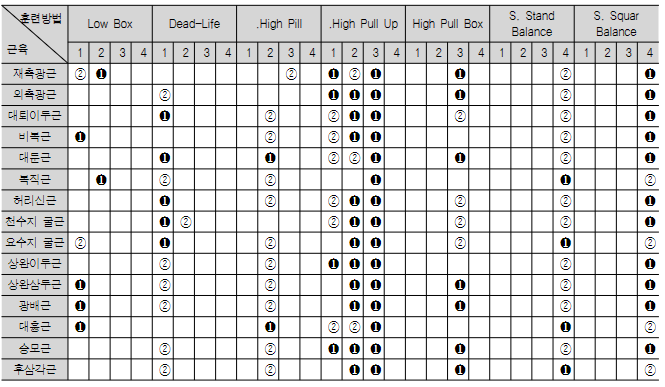

json: [{'훈련방법': 'Low Box', '지속중근': '1', '외측광근': '2', '대퇴이두근': '3', '비복근': '4', '대흉근': '1', '삼각근': '2', '전완근': '3', '척추기립근': '4', '하복근': '1', '상복근': '2', '오금근': '3', '상완이두근': '4', '상완삼두근': '1', '승모근': '2', '흉근': '3', '추수근근': '4'}, {'훈련방법': 'Dead-Life', '지속중근': '2', '외측광근': '3', '대퇴이두근': '4', '비복근': '1', '대흉근': '2', '삼각근': '3', '전완근': '4', '척추기립근': '1', '하복근': '2', '상복근': '3', '오금근': '4', '상완이두근': '1', '상완삼두근': '2', '승모근': '3', '흉근': '4', '추수근근': '1'}, {'훈련방법': 'High Pill', '지속중근': '3', '외측광근': '4', '대퇴이두근': '1', '비복근': '2', '대흉근': '3', '삼각근': '4', '전완근': '1', '척추기립근': '2', '하복근': '3', '상복근': '4', '오금근': '1', '상완이두근': '2', '상완삼두근': '3', '승모근': '4', '흉근': '1', '추수근근': '2'}, {'훈련방법': 'High Pull Up', '지속중근': '4', '외측광근': '1', '대퇴이두근': '2', '비복근': '3', '대흉근': '4', '삼각근': '1', '전완근': '2', '척추기립근': '3', '하복근': '4', '상복근': '1', '오금근': '2', '상완이두근': '3', '상완삼두근': '4', '승모근': '1', '흉근': '2', '추수근근': '3'}, {'훈련방법': 'High Pull Box', '지속중근': '1', '외측광근': '2', '대퇴이두근': '3', '비복근': '4', '대흉근': '1', '삼

In [33]:
draw_result(base_dataset[0], '../prompt/information_table/table_both_20250228_01.yaml', parser)

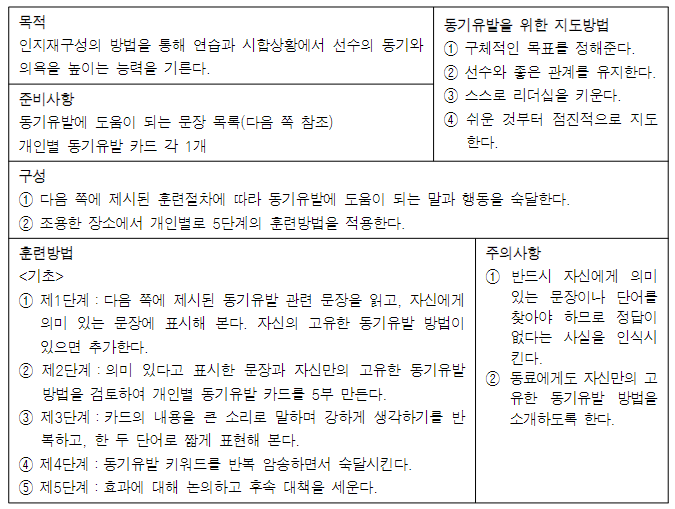

json: {'목적': {'내용': '인지구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기른다.'}, '준비사항': {'내용': '동기유발에 도움이 되는 문장 준비 (각 문장 쪽 찢음) 개인별 동기유발 문장 1개씩 배부'}, '구성': {'1단계': '다음 쪽에 제시된 훈련지침에 따라 동기유발이 도움이 되는 말과 행동을 구성하여 훈련한다.', '2단계': '다음 쪽에 제시된 훈련지침에 따라 동기유발이 도움이 되는 말과 행동을 구성하여 훈련한다.'}, '동기유발을 위한 지도방법': {'1': '구체적인 목표를 정해준다.', '2': '선수와 목표를 공유한다.', '3': '선수의 목표달성을 돕는다.'}, '주의사항': {'1': '훈련 시 자신에게 의미 있는 목표를 설정하도록 한다.', '2': '훈련 시 자신에게 의미 있는 목표를 설정하도록 한다.', '3': '훈련 시 자신에게 의미 있는 목표를 설정하도록 한다.'}}
detail: 이 표는 우수한 역도 선수의 동기유발 훈련방법을 설명하고 있다. 선수의 동기와 의욕을 높이는 방법으로 인지구성의 방법을 사용하며, 구체적인 목표 설정과 공유, 목표 달성을 돕는 지도방법이 포함되어 있다.
entity: ['동기유발', '훈련방법', '목표 설정', '지도방법']
hypotheticalQuestions: ['어떻게 하면 선수의 동기를 효과적으로 높일 수 있을까?', '동기유발 훈련방법이 선수의 성과에 미치는 영향은 무엇일까?', '구체적인 목표 설정이 선수의 동기유발에 어떤 역할을 할까?']
input: 463,  0.00116$, 2원
output: 718,  0.00718$, 10원


In [34]:
draw_result(base_dataset[1], '../prompt/information_table/table_both_20250228_01.yaml', parser)

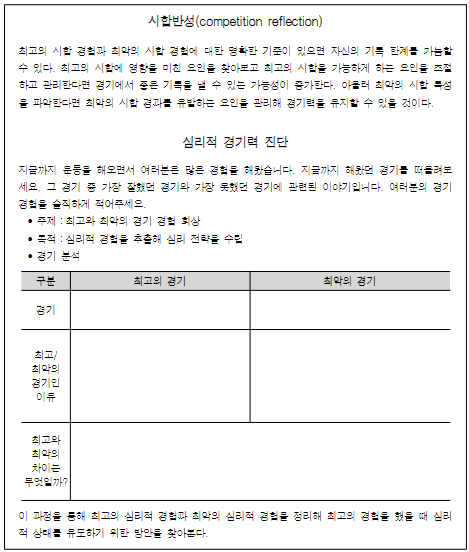

json: {'구분': ['최고의 경기', '최악의 경기'], '최고의 경기': ['경기 전', '경기 중', '경기 후'], '최악의 경기': ['경기 전', '경기 중', '경기 후']}
detail: 이 표는 심리기술훈련의 일환으로 시합 후 자기 반성을 통해 최고의 경기와 최악의 경기에서의 심리 상태를 분석하는 데 사용됩니다.
entity: ['심리기술훈련', '최고의 경기', '최악의 경기', '경기 전', '경기 중', '경기 후']
hypotheticalQuestions: ['어떻게 심리기술훈련이 경기 수행에 긍정적인 영향을 미칠 수 있을까?', '최고의 경기와 최악의 경기에서의 심리 상태는 어떻게 다를까?', '경기 전, 중, 후의 심리 상태를 개선하기 위한 전략은 무엇일까?']
input: 239,  0.0006$, 1원
output: 721,  0.00721$, 10원


In [35]:
draw_result(base_dataset[2], '../prompt/information_table/table_both_20250228_01.yaml', parser)

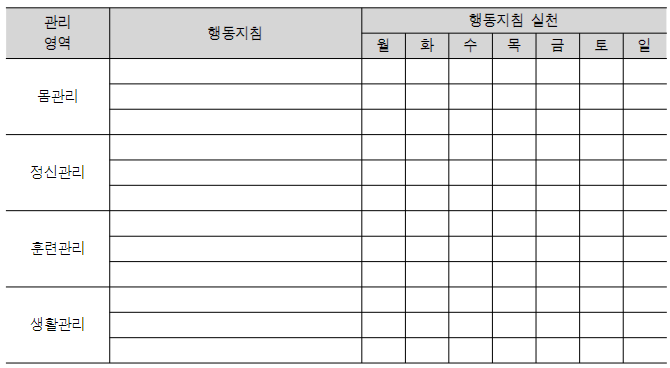

json: {'관리 영역': ['몸관리', '정신관리', '훈련관리', '생활관리'], '행동지침': ['', '', '', ''], '행동지침 실천': {'월': ['', '', '', ''], '화': ['', '', '', ''], '수': ['', '', '', ''], '목': ['', '', '', ''], '금': ['', '', '', ''], '토': ['', '', '', ''], '일': ['', '', '', '']}}
detail: 자기관리 훈련은 4단계로 진행되며, 우수 선수들의 공통점은 철저한 자기관리입니다. 자기관리는 자신감, 집중력, 목표설정, 의지력 다음으로 중요한 심리적 요인으로 나타났습니다.
entity: ['몸관리', '정신관리', '훈련관리', '생활관리', '자기관리', '행동지침']
hypotheticalQuestions: ['어떤 행동지침이 가장 효과적일까요?', '자기관리 기록표를 어떻게 활용할 수 있을까요?', '자기관리 훈련의 각 단계에서 어떤 도구가 필요할까요?', '자기관리가 심리적 요인에 미치는 영향은 무엇일까요?']
input: 329,  0.00082$, 1원
output: 775,  0.00775$, 11원


In [36]:
draw_result(base_dataset[3], '../prompt/information_table/table_both_20250228_01.yaml', parser)

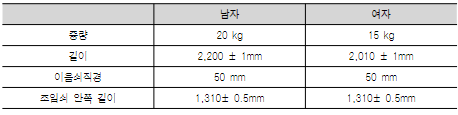

json: {'남자': {'중량': '20 kg', '길이': '2,200 ± 1mm', '이름쇠직경': '50 mm', '조임쇠 안쪽 길이': '1,310± 0.5mm'}, '여자': {'중량': '16 kg', '길이': '2,010 ± 1mm', '이름쇠직경': '50 mm', '조임쇠 안쪽 길이': '1,310± 0.5mm'}}
detail: 이 표는 국제역도연맹(IWF)에서 공인한 남자와 여자 역도 바의 규격을 나타냅니다. 남자 바는 20kg, 여자 바는 16kg이며, 두 바 모두 이름쇠 직경은 50mm입니다. 남자 바의 길이는 2,200 ± 1mm, 여자 바의 길이는 2,010 ± 1mm입니다. 조임쇠 안쪽 길이는 남녀 모두 1,310± 0.5mm입니다.
entity: ['남자 바', '여자 바', '국제역도연맹(IWF)', '중량', '길이', '이름쇠직경', '조임쇠 안쪽 길이']
hypotheticalQuestions: ['여자 바의 길이가 2,010mm보다 길면 어떤 영향을 미칠까요?', '남자 바의 중량이 20kg보다 가벼우면 경기 규정에 어떻게 영향을 줄까요?', '조임쇠 안쪽 길이가 1,310mm보다 짧으면 선수에게 어떤 영향을 줄까요?']
input: 387,  0.00097$, 1원
output: 736,  0.00736$, 11원


In [37]:
draw_result(base_dataset[4], '../prompt/information_table/table_both_20250228_01.yaml', parser)

### 프롬프트 2(S-U-A-A-U-A)

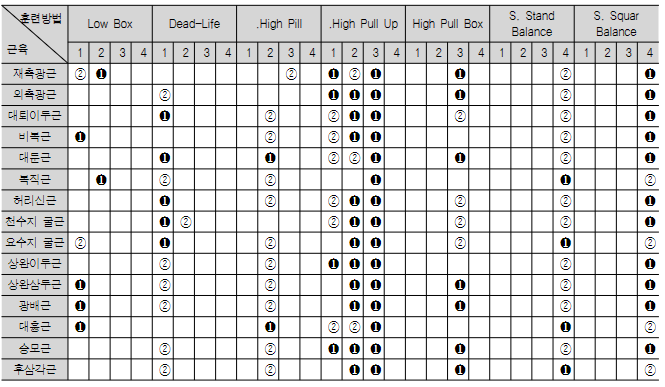

json: {'Low Box': {'1': ['지속중량', '의복착용'], '2': ['데드리프트', '비복근'], '3': ['대흉근', '대퇴근'], '4': ['하체스트레칭', '하체스트레칭']}, 'Dead-Lift': {'1': ['상완이두근', '상완삼두근'], '2': ['상완이두근', '상완삼두근'], '3': ['상완이두근', '상완삼두근'], '4': ['상완이두근', '상완삼두근']}, 'High Pull': {'1': ['상완이두근', '상완삼두근'], '2': ['상완이두근', '상완삼두근'], '3': ['상완이두근', '상완삼두근'], '4': ['상완이두근', '상완삼두근']}, 'High Pull Up': {'1': ['상완이두근', '상완삼두근'], '2': ['상완이두근', '상완삼두근'], '3': ['상완이두근', '상완삼두근'], '4': ['상완이두근', '상완삼두근']}, 'High Pull Box': {'1': ['상완이두근', '상완삼두근'], '2': ['상완이두근', '상완삼두근'], '3': ['상완이두근', '상완삼두근'], '4': ['상완이두근', '상완삼두근']}, 'S. Stand Balance': {'1': ['상완이두근', '상완삼두근'], '2': ['상완이두근', '상완삼두근'], '3': ['상완이두근', '상완삼두근'], '4': ['상완이두근', '상완삼두근']}, 'S. Squar Balance': {'1': ['상완이두근', '상완삼두근'], '2': ['상완이두근', '상완삼두근'], '3': ['상완이두근', '상완삼두근'], '4': ['상완이두근', '상완삼두근']}}
detail: 이 표는 다양한 보조프로그램에서 각 국면별로 주동근의 동원 순서를 보여줍니다. 예를 들어, 'Low Box' 프로그램에서는 1국면에서 '지속중량'과 '의복착용'이 주로 사용됩니다. 이는 특정 근육을 강화하기 위한 훈련 계획에 유용한 정보를 제공합니다.
entity: ['Low Box', 'Dead-

In [39]:
draw_result(base_dataset[0], '../prompt/information_table/table_both_20250301_01.yaml', parser)

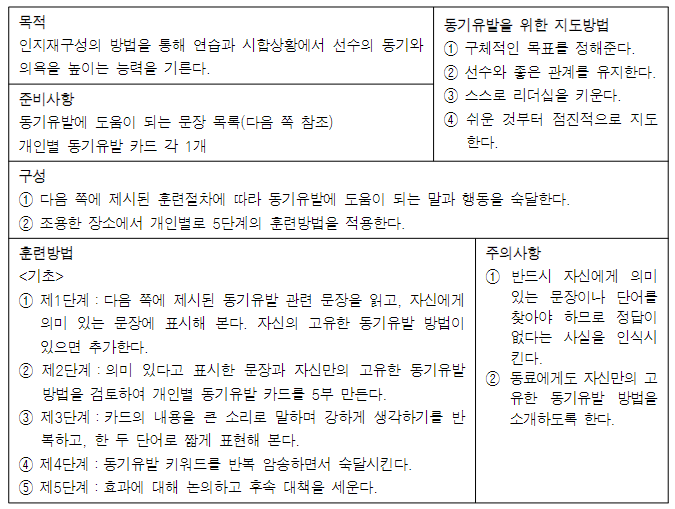

json: {'목적': '의지구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기른다.', '준비사항': '동기유발에 도움이 되는 문장 준비, 개인별 동기유발 문장 작성.', '구성': [{'1단계': '다음 책에 제시된 훈련지침에 따라 동기유발에 도움이 되는 말과 행동을 연습한다.'}, {'2단계': '다음 책에 제시된 훈련지침에 따라 동기유발에 도움이 되는 말과 행동을 연습한다.'}, {'3단계': '다음 책에 제시된 훈련지침에 따라 동기유발에 도움이 되는 말과 행동을 연습한다.'}], '주의사항': '1. 선수는 자신에게 의미 있는 목표를 설정해야 한다. 2. 선수의 목표는 구체적이고 실현 가능해야 한다. 3. 선수는 목표를 달성하기 위한 계획을 세워야 한다.', '동기유발을 위한 지도방법': '1. 구체적인 목표를 정해준다. 2. 선수와 함께 목표를 설정한다. 3. 목표 달성을 위한 계획을 세운다.'}
detail: 이 표는 동기유발 훈련방법에 대한 정보를 제공하며, 선수의 동기와 의욕을 높이는 방법을 설명하고 있다. 훈련의 목적은 의지구성의 방법을 통해 연습과 시험상황에서 선수의 동기와 의욕을 높이는 능력을 기르는 것이다. 준비사항으로는 동기유발에 도움이 되는 문장을 준비하고, 개인별 동기유발 문장을 작성하는 것이 포함된다. 구성은 3단계로 나뉘어 있으며, 각 단계에서 동기유발에 도움이 되는 말과 행동을 연습한다. 주의사항으로는 선수는 자신에게 의미 있는 목표를 설정하고, 목표는 구체적이고 실현 가능해야 하며, 목표 달성을 위한 계획을 세워야 한다는 점이 강조된다. 지도방법으로는 구체적인 목표를 정하고, 선수와 함께 목표를 설정하며, 목표 달성을 위한 계획을 세우는 것이 포함된다.
entity: ['동기유발', '훈련방법', '목표 설정', '의욕', '선수', '지도자']
hypotheticalQuestions: ['선수의 동기를 높이기 위해 어떤 구체적인 목표를 설정할 수 있을까?', '동기유발 문장을 작성할 때 어떤 요소

In [40]:
draw_result(base_dataset[1], '../prompt/information_table/table_both_20250301_01.yaml', parser)

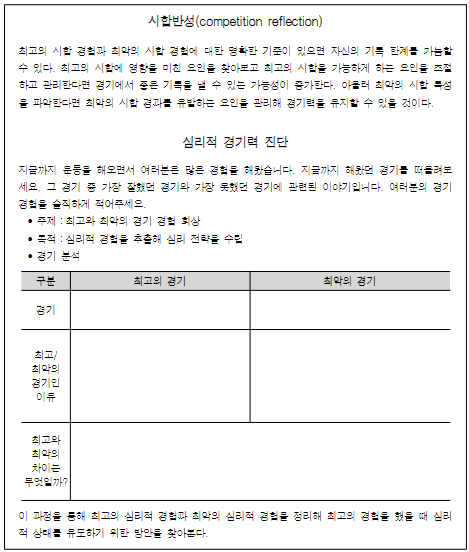

json: {'columns': ['구분', '최고의 경기', '최악의 경기'], 'rows': [{'구분': '최고의/최악의 경기 전', '최고의 경기': '', '최악의 경기': ''}, {'구분': '최고의/최악의 경기 중', '최고의 경기': '', '최악의 경기': ''}, {'구분': '최고의/최악의 경기 후', '최고의 경기': '', '최악의 경기': ''}]}
detail: 이 표는 선수들이 자신의 최고의 경기와 최악의 경기를 비교하여 심리적 상태를 분석할 수 있도록 돕는 자기 진단표입니다. 각 경기 전, 중, 후의 심리 상태를 기록하여 심리기술훈련에 활용할 수 있습니다.
entity: ['최고의 경기', '최악의 경기', '심리기술훈련', '심리 상태']
hypotheticalQuestions: ['선수들이 최고의 경기와 최악의 경기에서 공통적으로 느낀 심리적 차이는 무엇일까?', '심리기술훈련을 통해 선수들이 경기 전후로 어떤 변화를 경험할 수 있을까?', '경기 중 심리 상태가 경기 결과에 미치는 영향은 얼마나 클까?']
input: 313,  0.00078$, 1원
output: 749,  0.00749$, 11원


In [41]:
draw_result(base_dataset[2], '../prompt/information_table/table_both_20250301_01.yaml', parser)

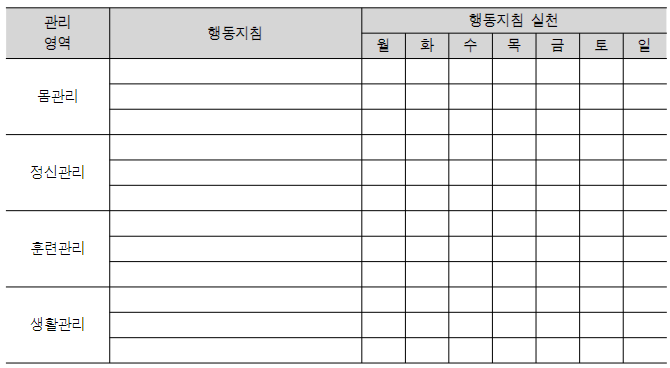

json: {'관리 영역': ['물관리', '정신관리', '훈련관리', '생활관리'], '행동지침': ['', '', '', ''], '행동지침 실천': {'월': ['', '', '', ''], '화': ['', '', '', ''], '수': ['', '', '', ''], '목': ['', '', '', ''], '금': ['', '', '', ''], '토': ['', '', '', ''], '일': ['', '', '', '']}}
detail: 이 표는 자기관리의 네 가지 영역(물관리, 정신관리, 훈련관리, 생활관리)에 대한 행동지침과 그 실천 여부를 기록하는 구조로 되어 있습니다. 각 영역에 대해 요일별로 실천 여부를 기록할 수 있습니다.
entity: ['물관리', '정신관리', '훈련관리', '생활관리', '행동지침', '행동지침 실천']
hypotheticalQuestions: ['어떤 행동지침이 가장 자주 실천되었는가?', '정신관리와 관련된 행동지침 실천이 선수의 경기력에 어떤 영향을 미치는가?', '생활관리 영역에서 가장 어려운 행동지침은 무엇인가?', '자기관리 기록표를 통해 선수의 심리적 요인을 어떻게 개선할 수 있는가?']
input: 343,  0.00086$, 1원
output: 804,  0.00804$, 12원


In [42]:
draw_result(base_dataset[3], '../prompt/information_table/table_both_20250301_01.yaml', parser)

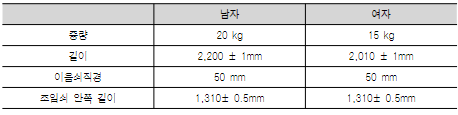

json: {'남자': {'중량': '20 kg', '길이': '2,200 ± 1mm', '이름쇠직경': '50 mm', '조임쇠 안쪽 길이': '1,310± 0.5mm'}, '여자': {'중량': '16 kg', '길이': '2,010 ± 1mm', '이름쇠직경': '50 mm', '조임쇠 안쪽 길이': '1,310± 0.5mm'}}
detail: 이 표는 국제역도연맹(IWF)에서 공인한 역도 바의 규격을 나타냅니다. 남자용 바는 20kg이며 길이는 2,200mm입니다. 여자용 바는 16kg이며 길이는 2,010mm입니다. 두 바 모두 이름쇠직경은 50mm이고, 조임쇠 안쪽 길이는 1,310mm입니다.
entity: ['남자용 바', '여자용 바', '중량', '길이', '이름쇠직경', '조임쇠 안쪽 길이']
hypotheticalQuestions: ['여자용 바의 중량이 남자용 바와 같다면 경기 결과에 어떤 영향을 미칠까요?', '조임쇠 안쪽 길이가 더 길어진다면 선수의 경기력에 어떤 변화가 있을까요?', '남자용 바의 길이가 줄어든다면 선수의 기술에 어떤 영향을 줄까요?']
input: 353,  0.00088$, 1원
output: 764,  0.00764$, 11원


In [43]:
draw_result(base_dataset[4], '../prompt/information_table/table_both_20250301_01.yaml', parser)